<a href="https://colab.research.google.com/github/footman2017/air_quality_classification_model/blob/main/Final_Tabnet%2C_LSTM%2C_CNN(hyperparameter_tunning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch_tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.4 MB/s eta 0:00:00


In [ ]:
from keras.layers import Dense, LSTM, Dropout, Conv1D, Flatten, MaxPooling1D
from keras.models import Sequential
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
from pytorch_tabnet.augmentations import ClassificationSMOTE
from pytorch_tabnet.callbacks import History
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.optimizers import Adam

In [ ]:
df = pd.read_csv('combined_data ver 1.1.csv')
df = df.replace('---', pd.NA)
df = df.dropna()
df.reset_index(drop=True, inplace=True)

df['pm10'] = df['pm10'].astype(int)
df['pm25'] = df['pm25'].astype(int)
df['so2'] = df['so2'].astype(int)
df['co'] = df['co'].astype(int)
df['o3'] = df['o3'].astype(int)
df['no2'] = df['no2'].astype(int)

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(df.drop('categori', axis=1).values)

# Save the scaler for future use
# joblib.dump(scaler, 'scaler.pkl')

# Reshape data for CNN
# X_cnn = X.reshape(-1, 6, 1)

# Convert categories to integers
encoder = LabelEncoder()
y = encoder.fit_transform(df['categori'].values)

# Get the original class labels and their integer encodings
original_classes = encoder.classes_
class_encodings = encoder.transform(original_classes)

# Print the original class labels and their corresponding integer encodings
for label, encoding in zip(original_classes, class_encodings):
    print(f"Original Class: {label}, Encoded Label: {encoding}")

y = to_categorical(y)

# Split the data into 90% training and 10% testing
X_train_90, X_test_10, y_train_90, y_test_10 = train_test_split(X, y, test_size=0.10, stratify=df['categori'])

Original Class: BAIK, Encoded Label: 0
Original Class: SEDANG, Encoded Label: 1
Original Class: TIDAK SEHAT, Encoded Label: 2


In [ ]:
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(units=57, input_shape=(X_train_90.shape[1], 1), return_sequences=True))
    model.add(LSTM(67))
    model.add(Dense(3, activation='softmax'))
    optimizer = Adam(learning_rate=0.0299223202049866)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Define the CNN model
def create_cnn_model(filters=32, kernel_size=2, dense_units=50, optimizer='adam'):
    model = Sequential()
    model.add(Conv1D(
        filters=filters,
        kernel_size=kernel_size,
        activation='relu',
        input_shape=(X.shape[1], 1)
        # input_shape=(6, 1)
    ))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model


clf = TabNetClassifier(
    n_d=41,
    n_a=16,
    n_steps=4,
    gamma=1.7624231694898185,
    momentum=0.3267370245261963,
    n_shared=1,
    n_independent=1,
    # scheduler_params={"step_size": 10, "gamma": 0.9},
    # scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=0
)

In [ ]:
def create_grafik (valid_loss, train_loss, train_accuracy, valid_accuracy):
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.plot(train_loss, label='Train Loss')
  plt.plot(valid_loss, label='Validation Loss')
  plt.legend()
  plt.show()

  # plot accuracy
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.plot(train_accuracy, label='Train Acc')
  plt.plot(valid_accuracy, label='Validation Acc')
  plt.legend()
  plt.show()

In [ ]:
def createConfusionMatrix(cm):
  # Plot the confusion matrix
  # plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Good", "Moderate", "Unhealthy"], yticklabels=["Good", "Moderate", "Unhealthy"])
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.title("Confusion Matrix")
  plt.show()

# k-cross valdiation


---- Training on Fold 1 ----
Stop training because you reached max_epochs = 75 with best_epoch = 31 and best_valid_accuracy = 0.99634
TabNet train and validation
              precision    recall  f1-score   support

           0     1.0000    0.9474    0.9730        19
           1     0.9952    1.0000    0.9976       206
           2     1.0000    1.0000    1.0000        48

    accuracy                         0.9963       273
   macro avg     0.9984    0.9825    0.9902       273
weighted avg     0.9964    0.9963    0.9963       273



/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


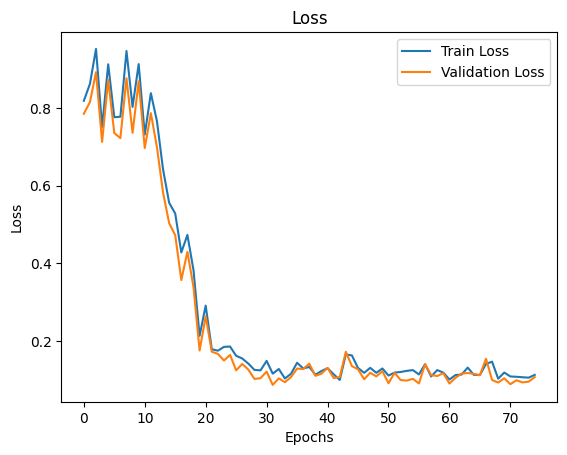

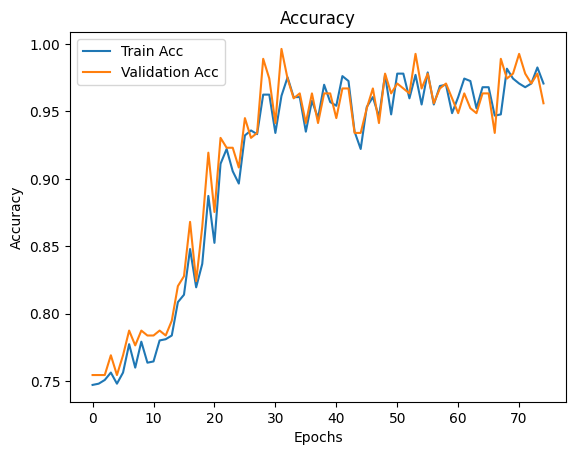

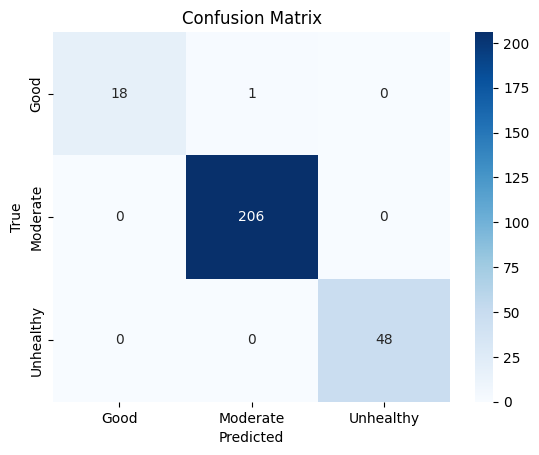

TabNet Test
              precision    recall  f1-score   support

           0     0.8571    1.0000    0.9231        12
           1     0.9912    0.9826    0.9869       115
           2     1.0000    0.9600    0.9796        25

    accuracy                         0.9803       152
   macro avg     0.9495    0.9809    0.9632       152
weighted avg     0.9821    0.9803    0.9807       152



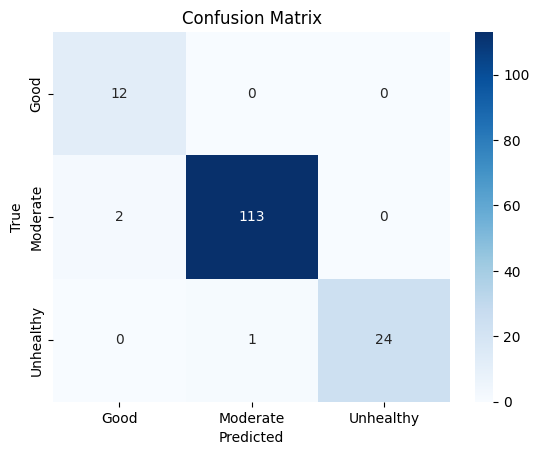

LSTM train and validation
9/9 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0     0.8947    0.8947    0.8947        19
           1     0.9853    0.9757    0.9805       206
           2     0.9400    0.9792    0.9592        48

    accuracy                         0.9707       273
   macro avg     0.9400    0.9499    0.9448       273
weighted avg     0.9710    0.9707    0.9708       273



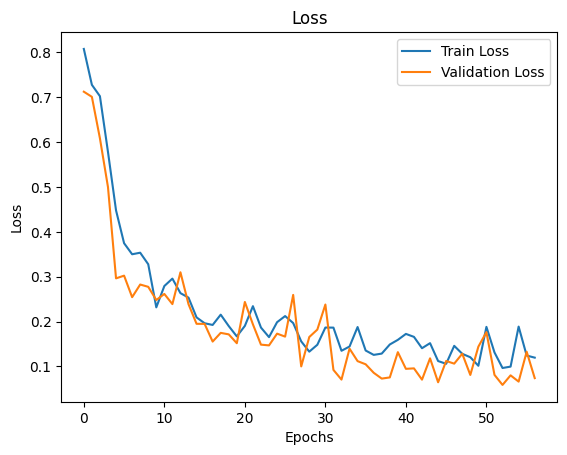

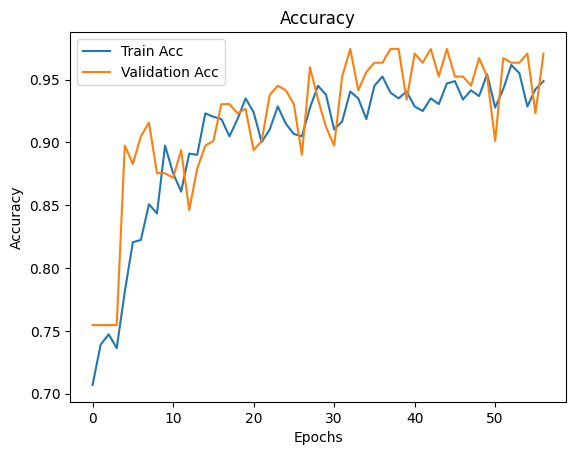

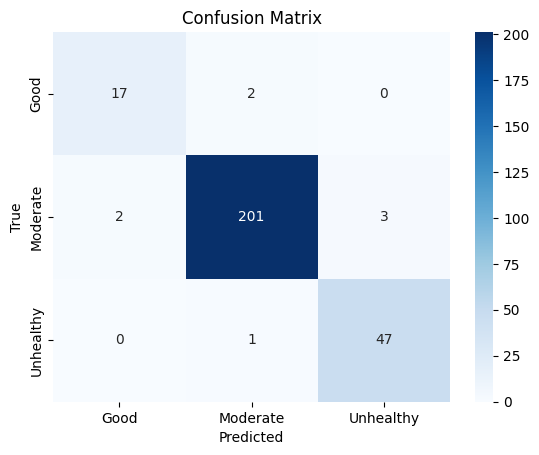

LSTM Test
5/5 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0     0.6875    0.9167    0.7857        12
           1     0.9820    0.9478    0.9646       115
           2     0.9600    0.9600    0.9600        25

    accuracy                         0.9474       152
   macro avg     0.8765    0.9415    0.9034       152
weighted avg     0.9551    0.9474    0.9497       152



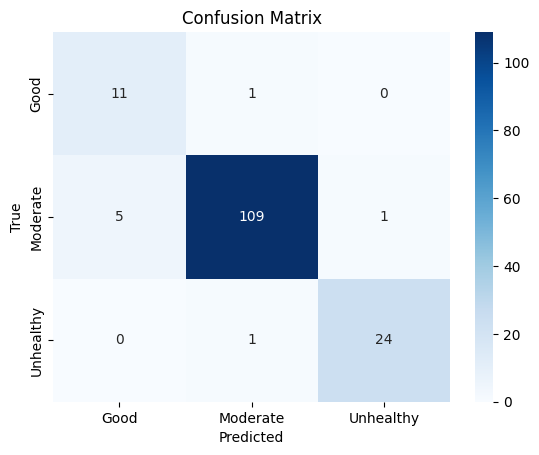

CNN train and validation
9/9 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0     1.0000    0.7895    0.8824        19
           1     0.9671    1.0000    0.9833       206
           2     1.0000    0.9375    0.9677        48

    accuracy                         0.9744       273
   macro avg     0.9890    0.9090    0.9445       273
weighted avg     0.9752    0.9744    0.9735       273



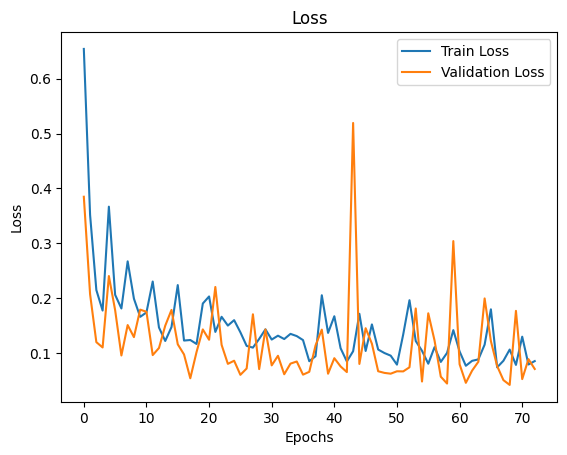

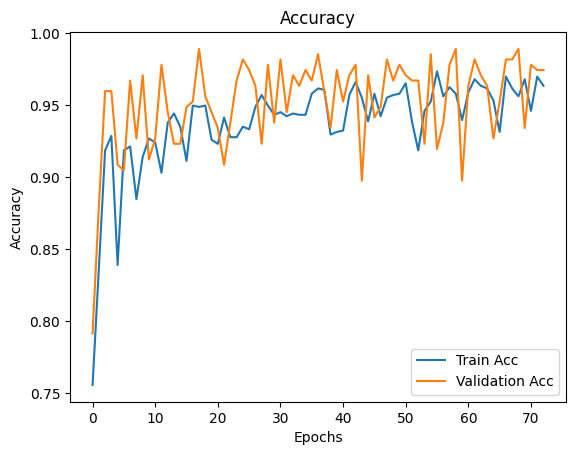

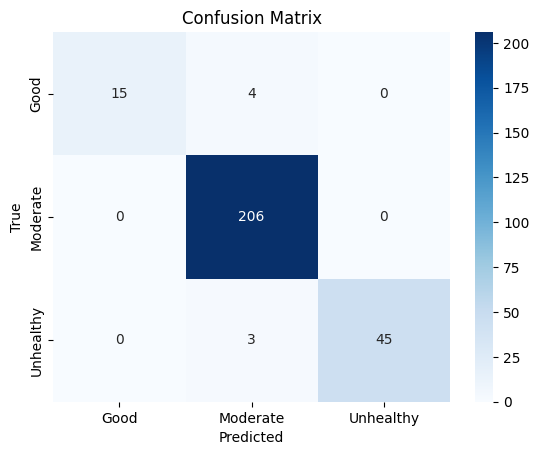

CNN Test
5/5 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0     1.0000    0.8333    0.9091        12
           1     0.9664    1.0000    0.9829       115
           2     1.0000    0.9200    0.9583        25

    accuracy                         0.9737       152
   macro avg     0.9888    0.9178    0.9501       152
weighted avg     0.9746    0.9737    0.9730       152



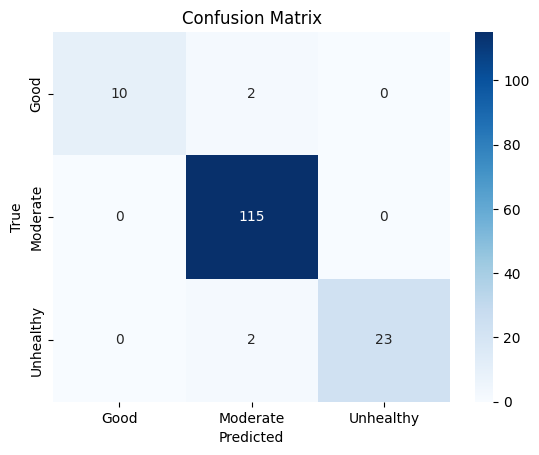


---- Training on Fold 2 ----
Stop training because you reached max_epochs = 75 with best_epoch = 67 and best_valid_accuracy = 0.9707


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


TabNet train and validation
              precision    recall  f1-score   support

           0     1.0000    0.8636    0.9268        22
           1     0.9714    0.9903    0.9808       206
           2     0.9545    0.9333    0.9438        45

    accuracy                         0.9707       273
   macro avg     0.9753    0.9291    0.9505       273
weighted avg     0.9709    0.9707    0.9703       273



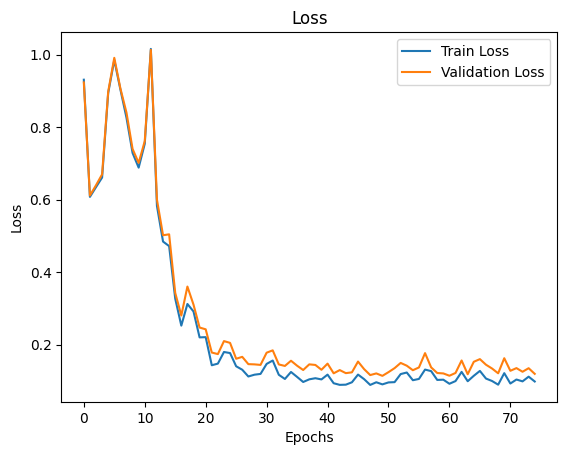

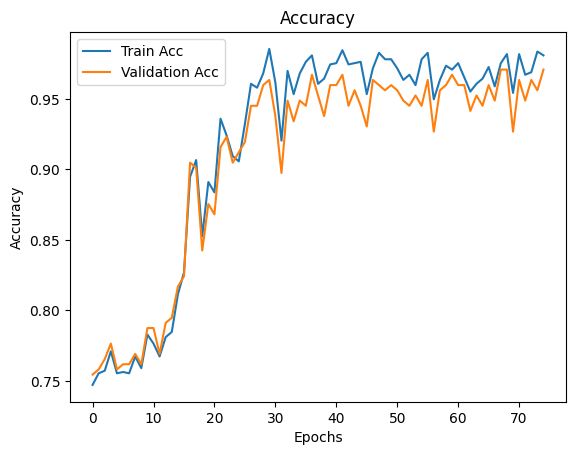

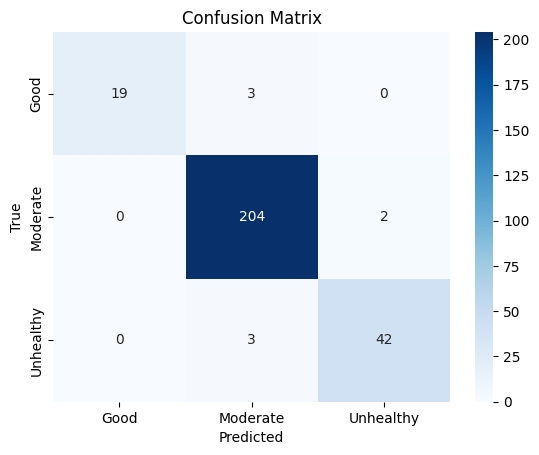

TabNet Test
              precision    recall  f1-score   support

           0     1.0000    0.9167    0.9565        12
           1     0.9576    0.9826    0.9700       115
           2     0.9130    0.8400    0.8750        25

    accuracy                         0.9539       152
   macro avg     0.9569    0.9131    0.9338       152
weighted avg     0.9536    0.9539    0.9533       152



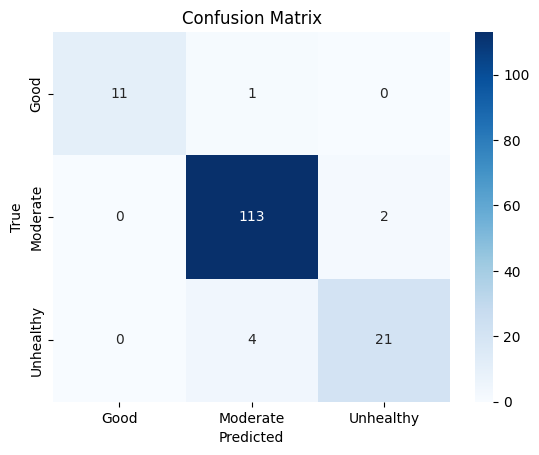

LSTM train and validation
9/9 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0     0.8824    0.6818    0.7692        22
           1     0.9606    0.9466    0.9535       206
           2     0.8302    0.9778    0.8980        45

    accuracy                         0.9304       273
   macro avg     0.8910    0.8687    0.8736       273
weighted avg     0.9328    0.9304    0.9295       273



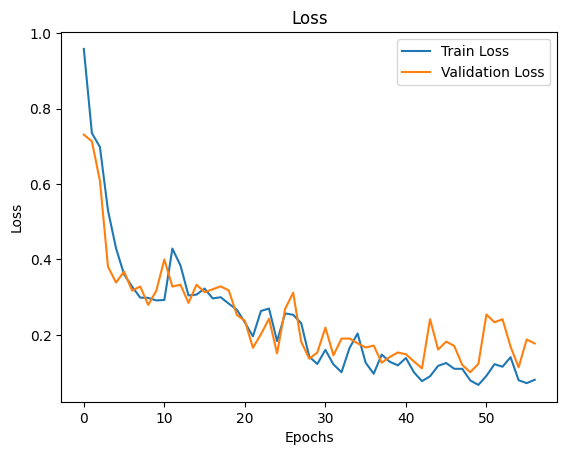

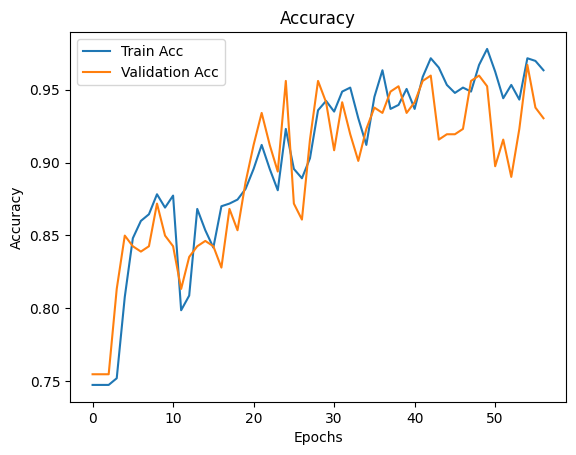

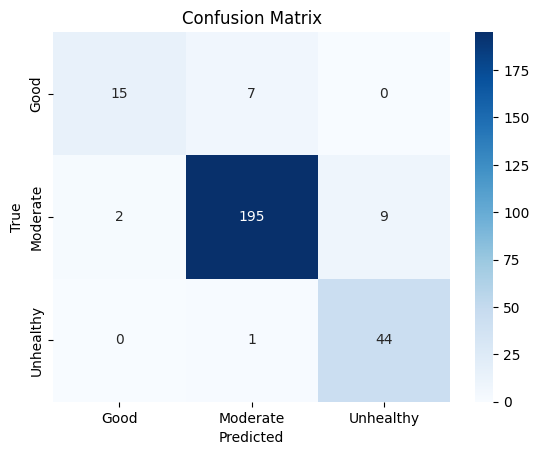

LSTM Test
5/5 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

           0     0.8333    0.8333    0.8333        12
           1     0.9820    0.9478    0.9646       115
           2     0.8621    1.0000    0.9259        25

    accuracy                         0.9474       152
   macro avg     0.8925    0.9271    0.9080       152
weighted avg     0.9505    0.9474    0.9479       152



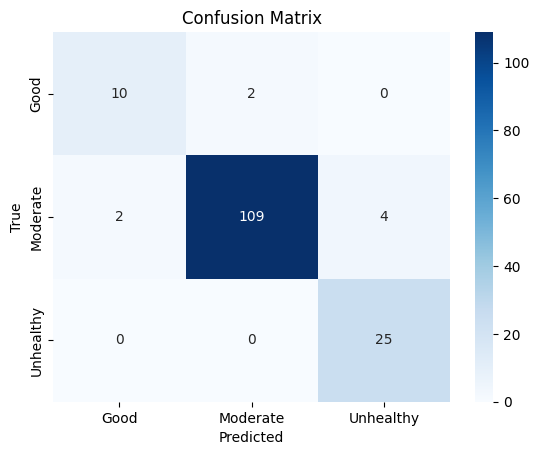

CNN train and validation
9/9 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0     0.9474    0.8182    0.8780        22
           1     0.9793    0.9175    0.9474       206
           2     0.7377    1.0000    0.8491        45

    accuracy                         0.9231       273
   macro avg     0.8881    0.9119    0.8915       273
weighted avg     0.9369    0.9231    0.9256       273



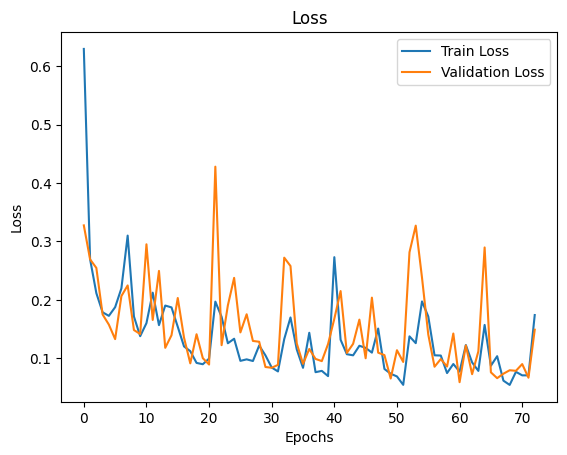

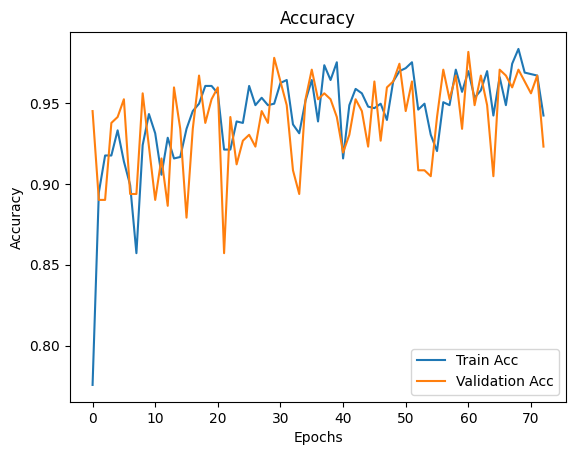

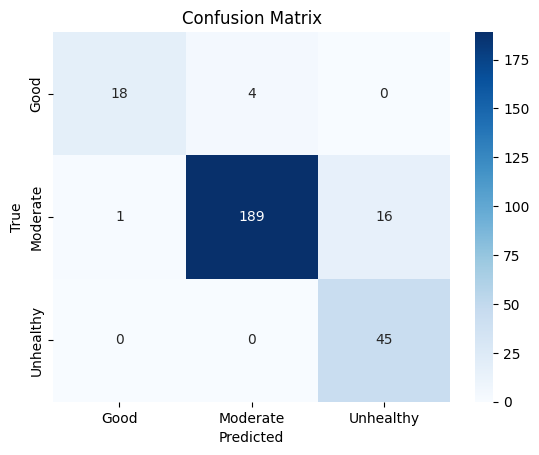

CNN Test
5/5 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0     0.9167    0.9167    0.9167        12
           1     0.9905    0.9043    0.9455       115
           2     0.7143    1.0000    0.8333        25

    accuracy                         0.9211       152
   macro avg     0.8738    0.9403    0.8985       152
weighted avg     0.9392    0.9211    0.9247       152



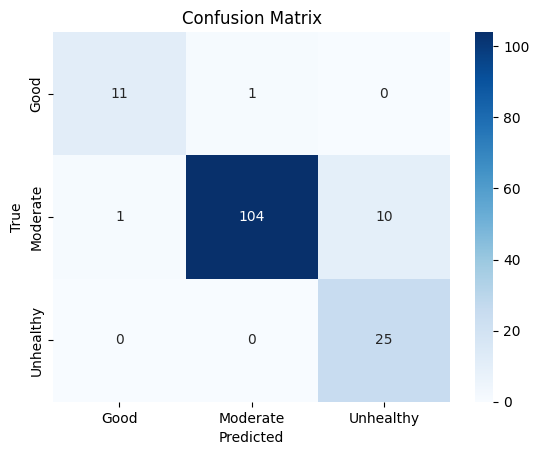


---- Training on Fold 3 ----
Stop training because you reached max_epochs = 75 with best_epoch = 35 and best_valid_accuracy = 0.98535


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


TabNet train and validation
              precision    recall  f1-score   support

           0     1.0000    0.8571    0.9231        21
           1     0.9858    0.9952    0.9905       209
           2     0.9773    1.0000    0.9885        43

    accuracy                         0.9853       273
   macro avg     0.9877    0.9508    0.9674       273
weighted avg     0.9855    0.9853    0.9850       273



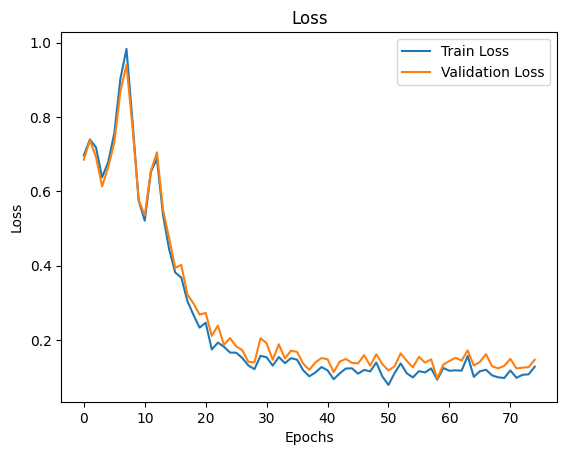

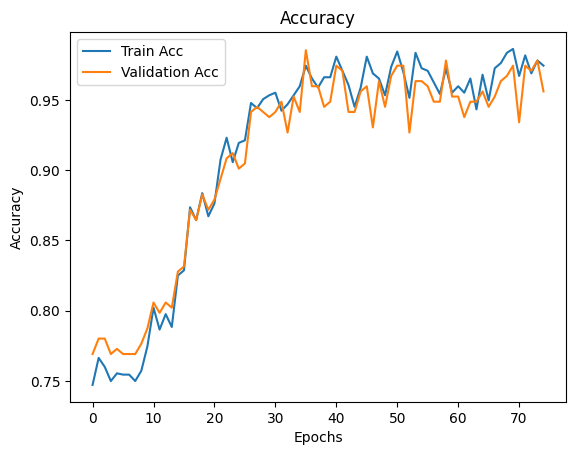

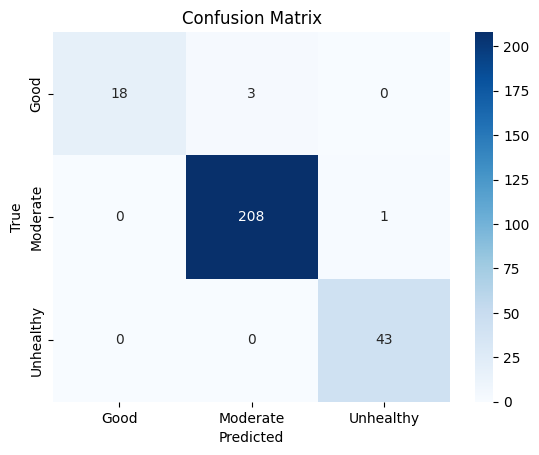

TabNet Test
              precision    recall  f1-score   support

           0     0.7500    0.7500    0.7500        12
           1     0.9739    0.9739    0.9739       115
           2     1.0000    1.0000    1.0000        25

    accuracy                         0.9605       152
   macro avg     0.9080    0.9080    0.9080       152
weighted avg     0.9605    0.9605    0.9605       152



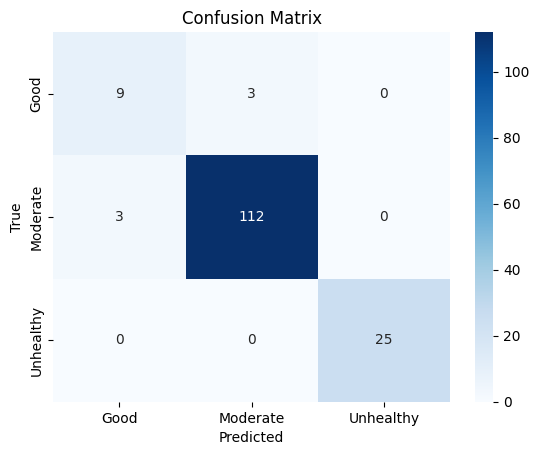

LSTM train and validation
9/9 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

           0     1.0000    0.6190    0.7647        21
           1     0.9626    0.9856    0.9740       209
           2     0.9348    1.0000    0.9663        43

    accuracy                         0.9597       273
   macro avg     0.9658    0.8682    0.9017       273
weighted avg     0.9611    0.9597    0.9567       273



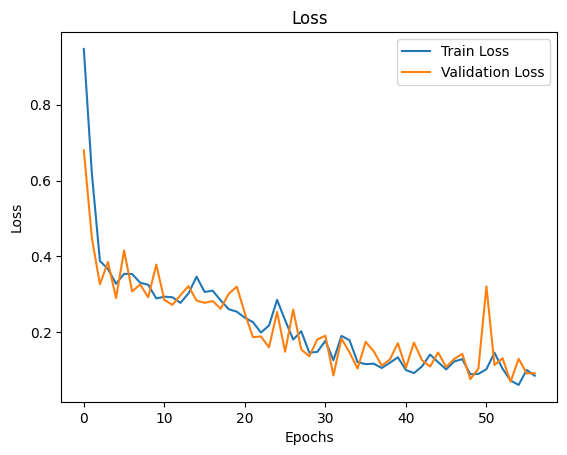

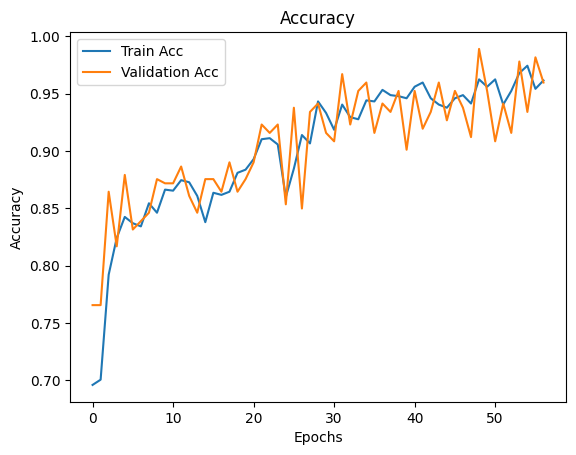

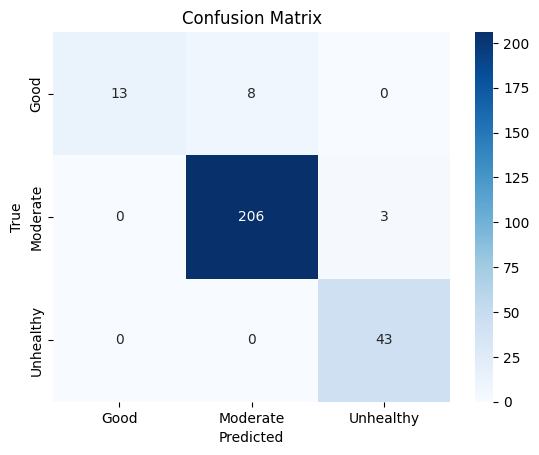

LSTM Test
5/5 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0     1.0000    0.6667    0.8000        12
           1     0.9583    1.0000    0.9787       115
           2     1.0000    0.9600    0.9796        25

    accuracy                         0.9671       152
   macro avg     0.9861    0.8756    0.9194       152
weighted avg     0.9685    0.9671    0.9648       152



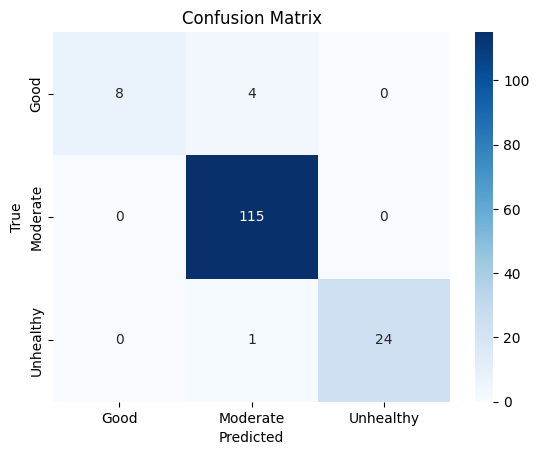

CNN train and validation
9/9 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0     1.0000    0.9524    0.9756        21
           1     0.9952    0.9856    0.9904       209
           2     0.9348    1.0000    0.9663        43

    accuracy                         0.9853       273
   macro avg     0.9767    0.9793    0.9774       273
weighted avg     0.9860    0.9853    0.9855       273



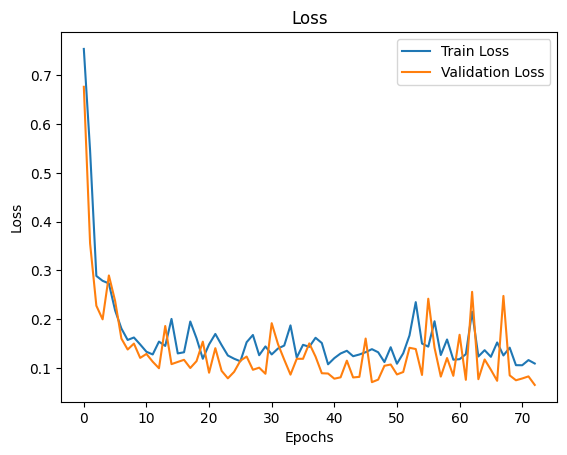

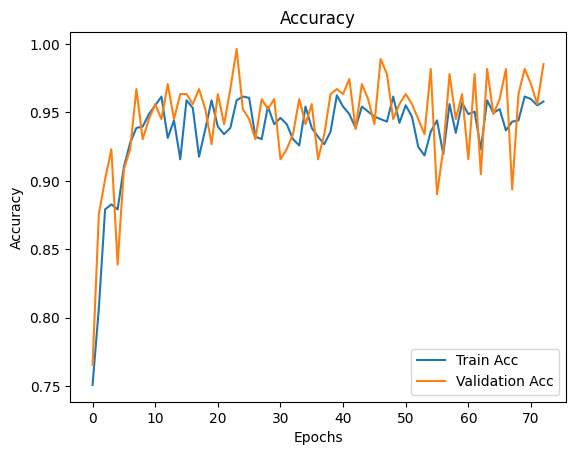

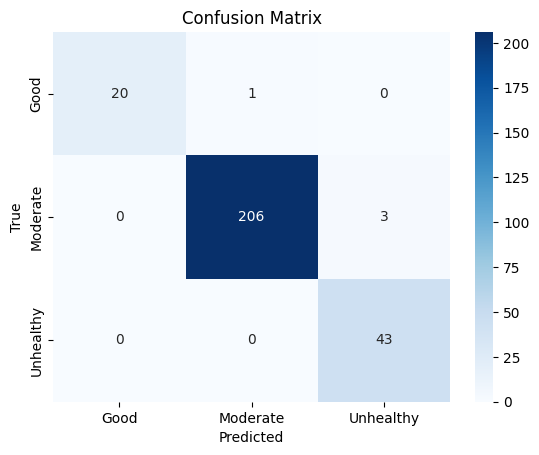

CNN Test
5/5 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0     0.7692    0.8333    0.8000        12
           1     0.9820    0.9478    0.9646       115
           2     0.8929    1.0000    0.9434        25

    accuracy                         0.9474       152
   macro avg     0.8814    0.9271    0.9027       152
weighted avg     0.9505    0.9474    0.9481       152



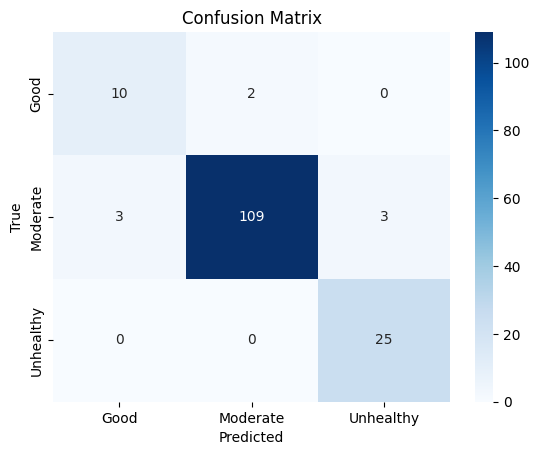


---- Training on Fold 4 ----
Stop training because you reached max_epochs = 75 with best_epoch = 32 and best_valid_accuracy = 0.98535
TabNet train and validation
              precision    recall  f1-score   support

           0     1.0000    0.8889    0.9412        18
           1     0.9855    0.9951    0.9903       205
           2     0.9800    0.9800    0.9800        50

    accuracy                         0.9853       273
   macro avg     0.9885    0.9547    0.9705       273
weighted avg     0.9855    0.9853    0.9852       273



/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


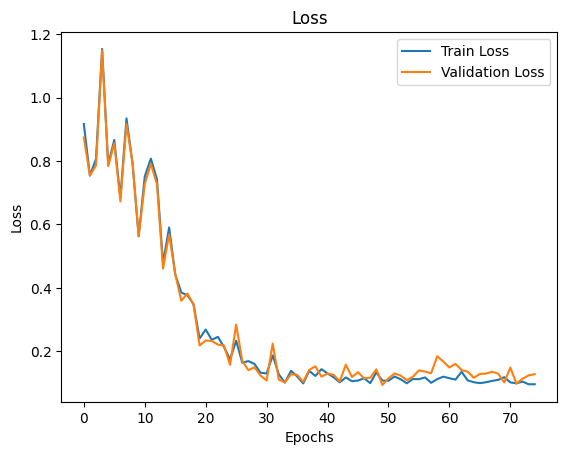

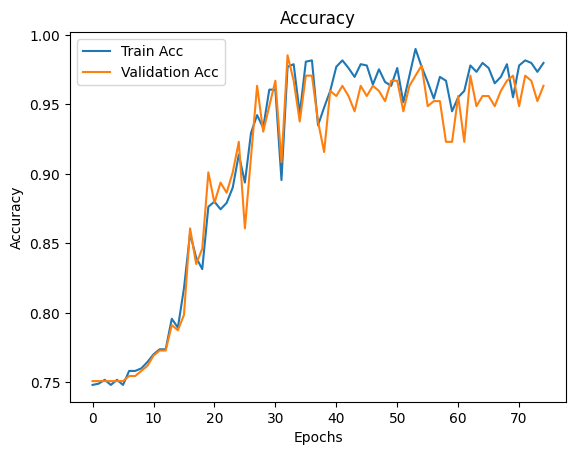

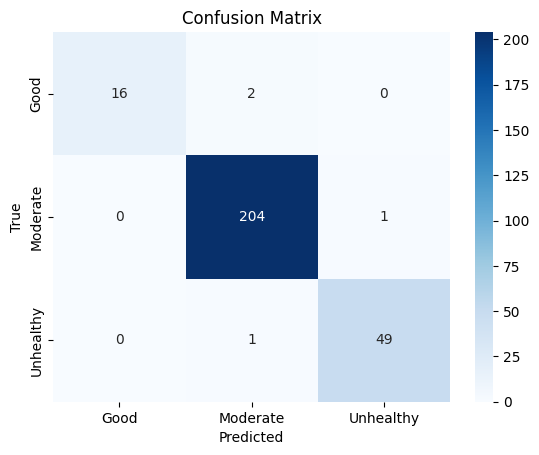

TabNet Test
              precision    recall  f1-score   support

           0     1.0000    0.8333    0.9091        12
           1     0.9829    1.0000    0.9914       115
           2     1.0000    1.0000    1.0000        25

    accuracy                         0.9868       152
   macro avg     0.9943    0.9444    0.9668       152
weighted avg     0.9871    0.9868    0.9863       152



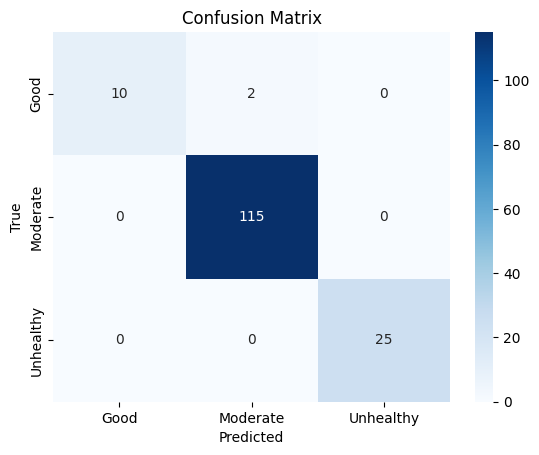

LSTM train and validation
9/9 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0     0.8947    0.9444    0.9189        18
           1     0.9950    0.9805    0.9877       205
           2     0.9615    1.0000    0.9804        50

    accuracy                         0.9817       273
   macro avg     0.9504    0.9750    0.9623       273
weighted avg     0.9823    0.9817    0.9818       273



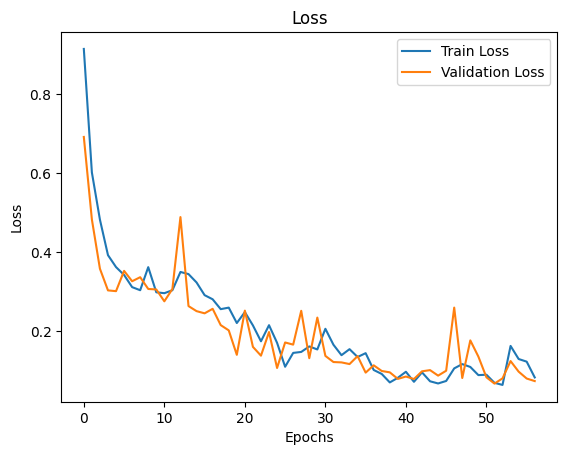

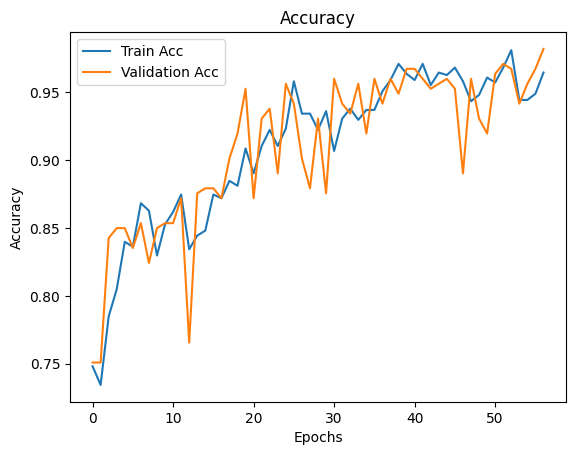

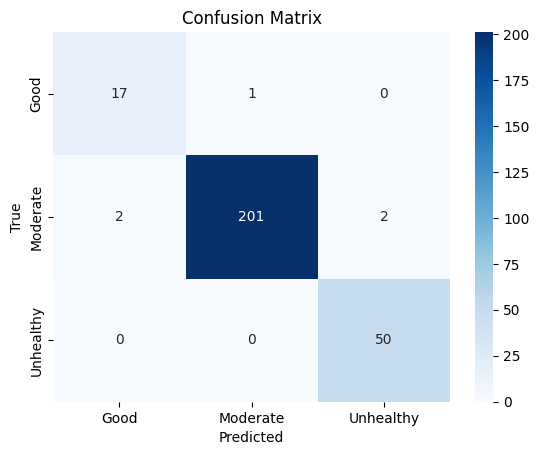

LSTM Test
5/5 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0     0.9231    1.0000    0.9600        12
           1     1.0000    0.9913    0.9956       115
           2     1.0000    1.0000    1.0000        25

    accuracy                         0.9934       152
   macro avg     0.9744    0.9971    0.9852       152
weighted avg     0.9939    0.9934    0.9935       152



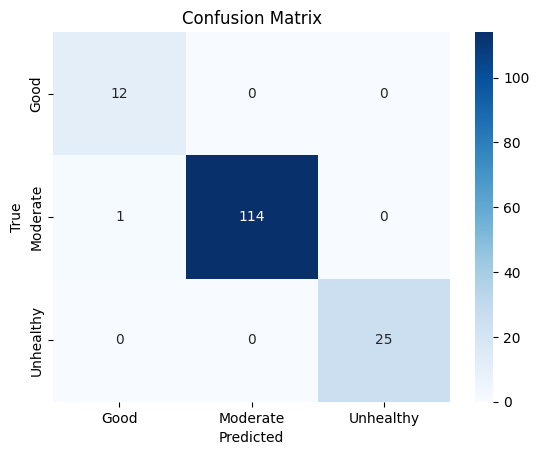

CNN train and validation
9/9 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0     0.7619    0.8889    0.8205        18
           1     0.9431    0.9707    0.9567       205
           2     0.9756    0.8000    0.8791        50

    accuracy                         0.9341       273
   macro avg     0.8935    0.8865    0.8855       273
weighted avg     0.9371    0.9341    0.9335       273



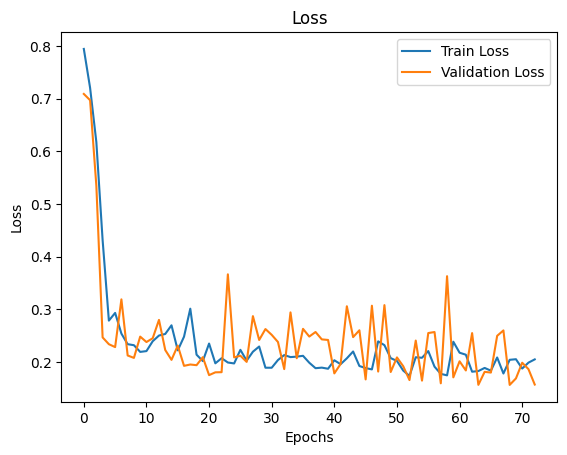

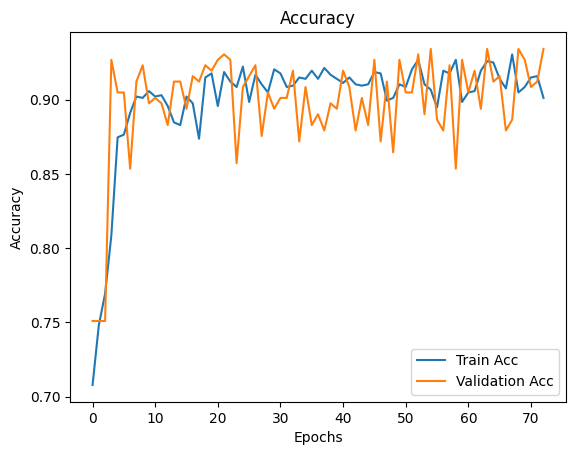

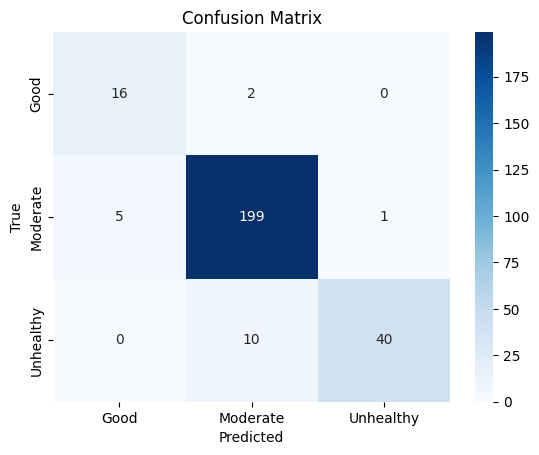

CNN Test
5/5 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0     0.6364    0.5833    0.6087        12
           1     0.9464    0.9217    0.9339       115
           2     0.8276    0.9600    0.8889        25

    accuracy                         0.9013       152
   macro avg     0.8035    0.8217    0.8105       152
weighted avg     0.9024    0.9013    0.9008       152



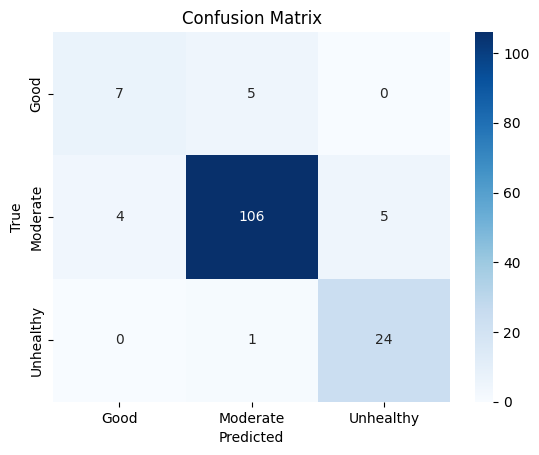


---- Training on Fold 5 ----
Stop training because you reached max_epochs = 75 with best_epoch = 39 and best_valid_accuracy = 0.9707


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


TabNet train and validation
              precision    recall  f1-score   support

           0     0.8148    0.9565    0.8800        23
           1     0.9896    0.9694    0.9794       196
           2     0.9815    0.9815    0.9815        54

    accuracy                         0.9707       273
   macro avg     0.9286    0.9691    0.9470       273
weighted avg     0.9733    0.9707    0.9714       273



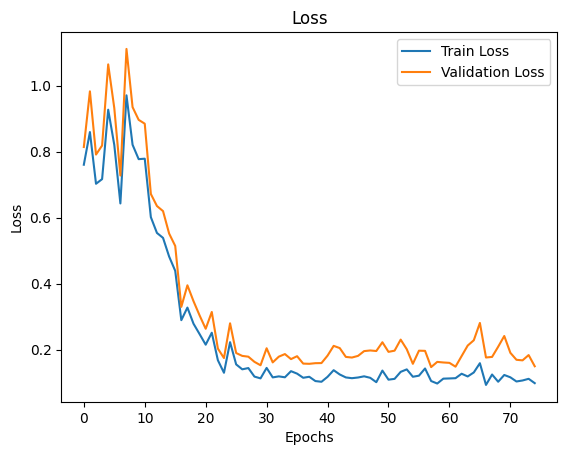

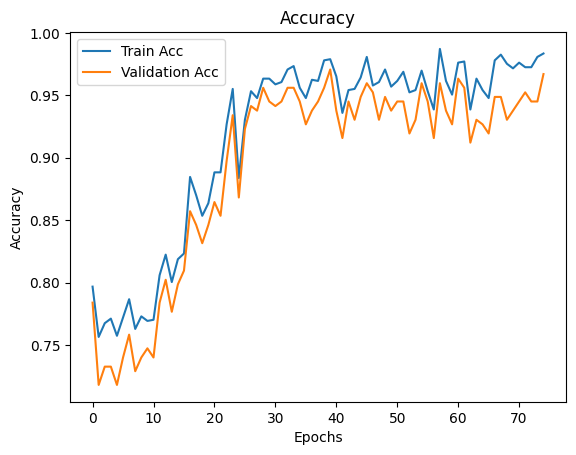

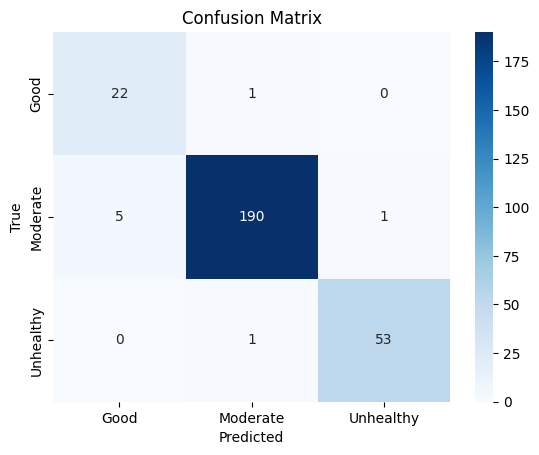

TabNet Test
              precision    recall  f1-score   support

           0     0.8000    1.0000    0.8889        12
           1     1.0000    0.9478    0.9732       115
           2     0.8929    1.0000    0.9434        25

    accuracy                         0.9605       152
   macro avg     0.8976    0.9826    0.9352       152
weighted avg     0.9666    0.9605    0.9617       152



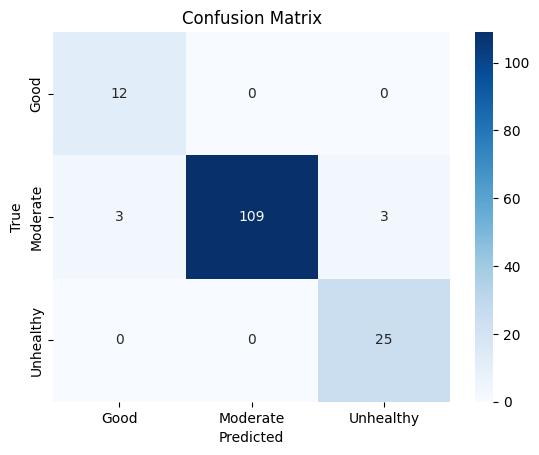

LSTM train and validation
9/9 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0     0.7917    0.8261    0.8085        23
           1     0.9598    0.9745    0.9671       196
           2     1.0000    0.9259    0.9615        54

    accuracy                         0.9524       273
   macro avg     0.9172    0.9088    0.9124       273
weighted avg     0.9536    0.9524    0.9526       273



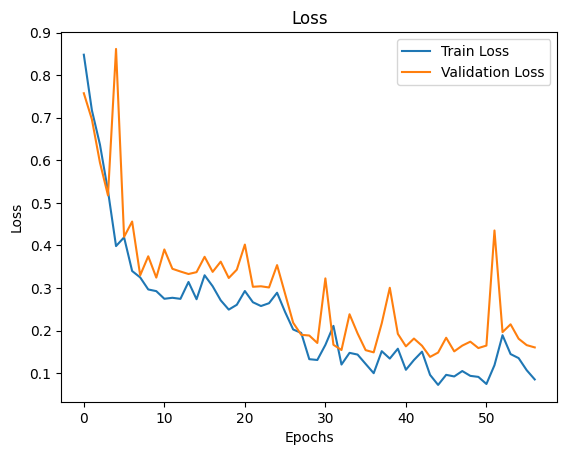

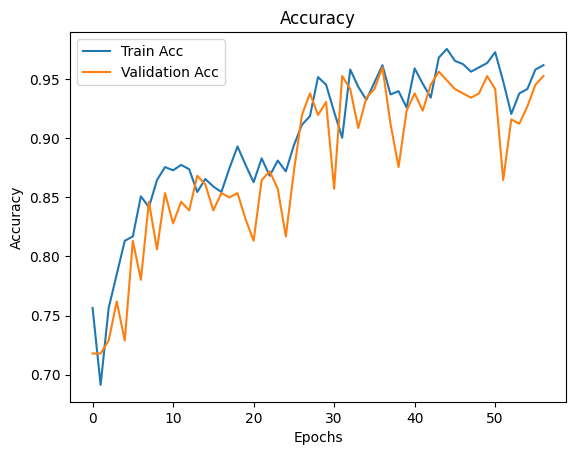

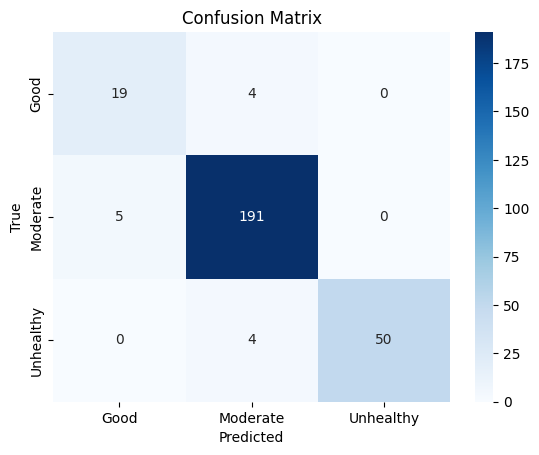

LSTM Test
5/5 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0     0.7692    0.8333    0.8000        12
           1     0.9739    0.9739    0.9739       115
           2     1.0000    0.9600    0.9796        25

    accuracy                         0.9605       152
   macro avg     0.9144    0.9224    0.9178       152
weighted avg     0.9620    0.9605    0.9611       152



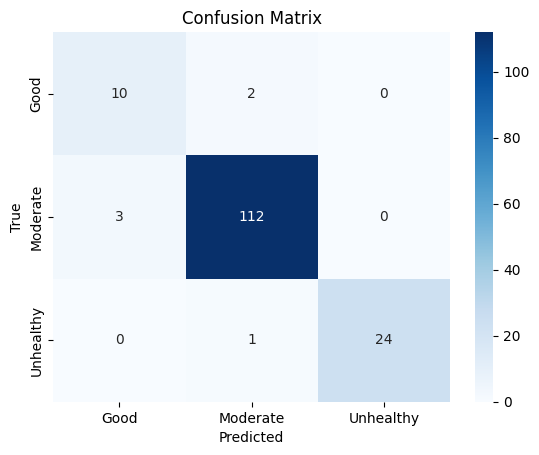

CNN train and validation
9/9 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0     0.7692    0.8696    0.8163        23
           1     0.9794    0.9694    0.9744       196
           2     1.0000    0.9815    0.9907        54

    accuracy                         0.9634       273
   macro avg     0.9162    0.9401    0.9271       273
weighted avg     0.9658    0.9634    0.9643       273



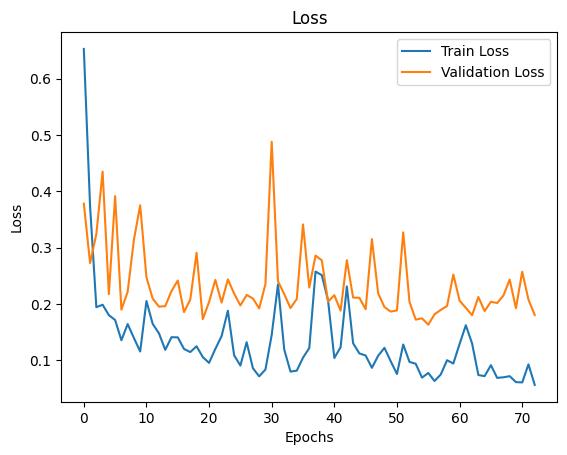

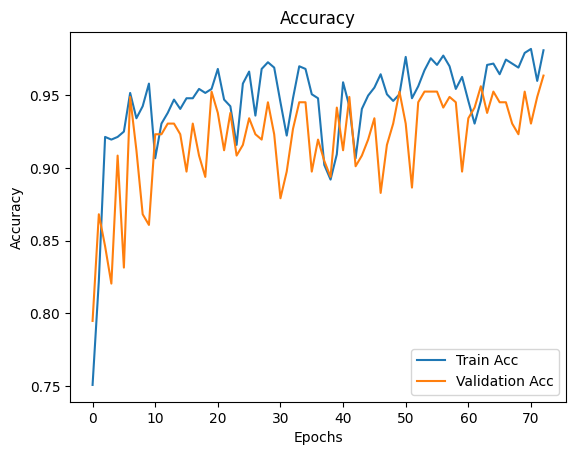

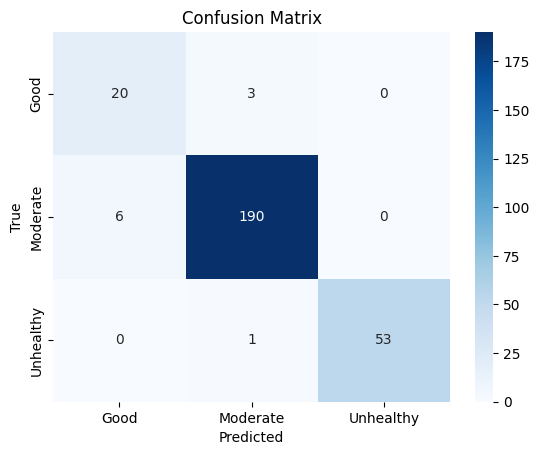

CNN Test
5/5 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0     0.7857    0.9167    0.8462        12
           1     0.9912    0.9739    0.9825       115
           2     1.0000    1.0000    1.0000        25

    accuracy                         0.9737       152
   macro avg     0.9256    0.9635    0.9429       152
weighted avg     0.9764    0.9737    0.9746       152



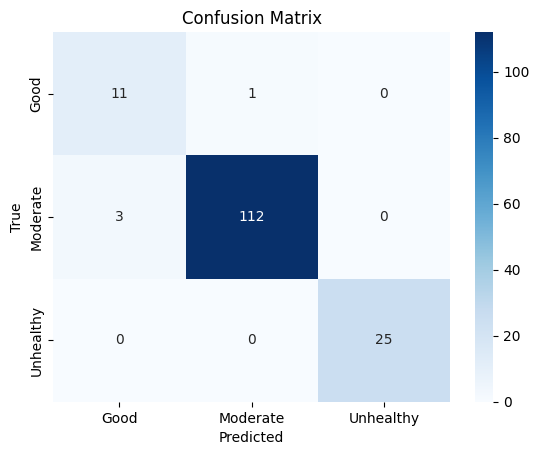


LSTM Average accuracy over 5-fold CV: 95.90%
CNN Average accuracy over 5-fold CV: 95.60%
Tabnet Average accuracy over 5-fold CV: 98.17%


In [ ]:
n_splits = 5
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=9)
aug = ClassificationSMOTE(p=0.2)

acc_per_fold_lstm = []
acc_per_fold_cnn = []
acc_per_fold_tabnet = []

y_test_10_tabnet = np.argmax(y_test_10, axis=1)

for fold, (train, test) in enumerate(kfold.split(X_train_90, np.argmax(y_train_90, axis=1))):
    print(f"\n---- Training on Fold {fold + 1} ----")

    model_lstm = create_lstm_model()
    model_cnn = create_cnn_model(
        filters=38,
        kernel_size=3,
        dense_units=36,
        optimizer=Adam(learning_rate=0.07424181556238957)
    )

    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]

    y_train_tabnet = np.argmax(y_train, axis=1)
    y_test_tabnet = np.argmax(y_test, axis=1)

    #BEGIN Tabnet
    clf.fit(
        X_train, y_train_tabnet,
        eval_set=[(X_train, y_train_tabnet), (X_test, y_test_tabnet)],
        eval_name=['train', 'valid'],
        eval_metric=['logloss', 'accuracy'],
        max_epochs=75,
        patience=100,
        augmentations=aug,
        batch_size=50
    )

    predictions = clf.predict(X_test)
    accuracy = np.mean(predictions == y_test_tabnet)
    confusion = confusion_matrix(y_test_tabnet, predictions, labels=[0, 1, 2])    # Calculate the confusion matrix
    acc_per_fold_tabnet.append(accuracy * 100)
    print("TabNet train and validation")
    print(classification_report(y_test_tabnet, predictions, digits=4))
    create_grafik (
        train_loss=clf.history['train_logloss'],
        valid_loss=clf.history['valid_logloss'],
        train_accuracy=clf.history['train_accuracy'],
        valid_accuracy=clf.history['valid_accuracy']
    )
    createConfusionMatrix(confusion)

    predictions = clf.predict(X_test_10)
    # accuracy = np.mean(predictions == y_test_10_tabnet)
    print("TabNet Test")
    print(classification_report(y_test_10_tabnet, predictions, digits=4))
    confusion = confusion_matrix(y_test_10_tabnet, predictions, labels=[0, 1, 2])    # Calculate the confusion matrix
    createConfusionMatrix(confusion)

    #END Tabnet

    #BEGIN LSTM
    history_lstm = model_lstm.fit(X_train, y_train, epochs=57, batch_size=91, verbose=0, validation_data=(X_test, y_test))

    print("LSTM train and validation")
    scores = model_lstm.evaluate(X_test, y_test, verbose=0)
    acc_per_fold_lstm.append(scores[1] * 100)
    y_test_int = np.argmax(y_test, axis=1)
    y_pred = model_lstm.predict(X_test)
    confusion = confusion_matrix(y_test_int, np.argmax(y_pred, axis=1), labels=[0, 1, 2])    # Calculate the confusion matrix
    print(classification_report(y_test_int, np.argmax(y_pred, axis=1), digits=4))
    create_grafik (
        valid_loss=history_lstm.history['val_loss'],
        train_loss=history_lstm.history['loss'],
        train_accuracy=history_lstm.history['accuracy'],
        valid_accuracy=history_lstm.history['val_accuracy'],
    )
    createConfusionMatrix(confusion)

    print("LSTM Test")
    y_test_int = np.argmax(y_test_10, axis=1)
    y_pred = model_lstm.predict(X_test_10)
    print(classification_report(y_test_int, np.argmax(y_pred, axis=1), digits=4))
    confusion = confusion_matrix(y_test_int, np.argmax(y_pred, axis=1), labels=[0, 1, 2])    # Calculate the confusion matrix
    createConfusionMatrix(confusion)

    #END LSTM


    #BEGIN CNN
    history_cnn = model_cnn.fit(X_train, y_train, epochs=73, batch_size=44, verbose=0, validation_data=(X_test, y_test))
    print("CNN train and validation")
    scores = model_cnn.evaluate(X_test, y_test, verbose=0)
    acc_per_fold_cnn.append(scores[1] * 100)
    y_pred = model_cnn.predict(X_test)
    y_test_int = np.argmax(y_test, axis=1)
    print(classification_report(y_test_int, np.argmax(y_pred, axis=1), digits=4))
    create_grafik (
        valid_loss=history_cnn.history['val_loss'],
        train_loss=history_cnn.history['loss'],
        train_accuracy=history_cnn.history['accuracy'],
        valid_accuracy=history_cnn.history['val_accuracy'],
    )
    confusion = confusion_matrix(y_test_int, np.argmax(y_pred, axis=1), labels=[0, 1, 2])    # Calculate the confusion matrix
    createConfusionMatrix(confusion)

    print("CNN Test")
    y_test_int = np.argmax(y_test_10, axis=1)
    y_pred = model_cnn.predict(X_test_10)
    print(classification_report(y_test_int, np.argmax(y_pred, axis=1), digits=4))
    confusion = confusion_matrix(y_test_int, np.argmax(y_pred, axis=1), labels=[0, 1, 2])    # Calculate the confusion matrix
    createConfusionMatrix(confusion)

    #--END report--#

print(
    f"\nLSTM Average accuracy over {n_splits}-fold CV: {np.mean(acc_per_fold_lstm):.2f}%")

print(
    f"CNN Average accuracy over {n_splits}-fold CV: {np.mean(acc_per_fold_cnn):.2f}%")

print(
    f"Tabnet Average accuracy over {n_splits}-fold CV: {np.mean(acc_per_fold_tabnet):.2f}%")



---- Training on Fold 1 ----
Stop training because you reached max_epochs = 75 with best_epoch = 38 and best_valid_accuracy = 0.98168
TabNet train and validation
              precision    recall  f1-score   support

           0     0.8800    0.9565    0.9167        23
           1     0.9948    0.9795    0.9871       195
           2     0.9821    1.0000    0.9910        55

    accuracy                         0.9817       273
   macro avg     0.9523    0.9787    0.9649       273
weighted avg     0.9826    0.9817    0.9819       273



/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


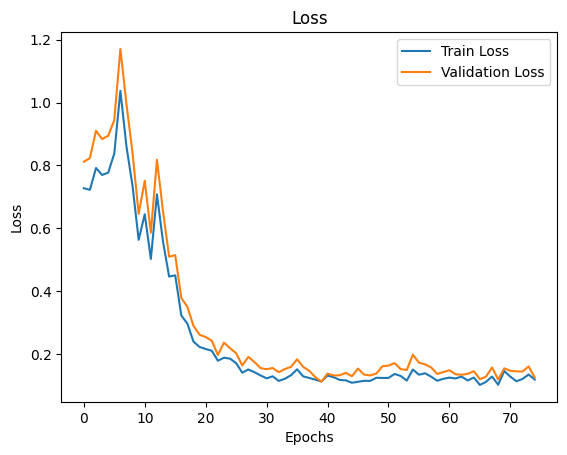

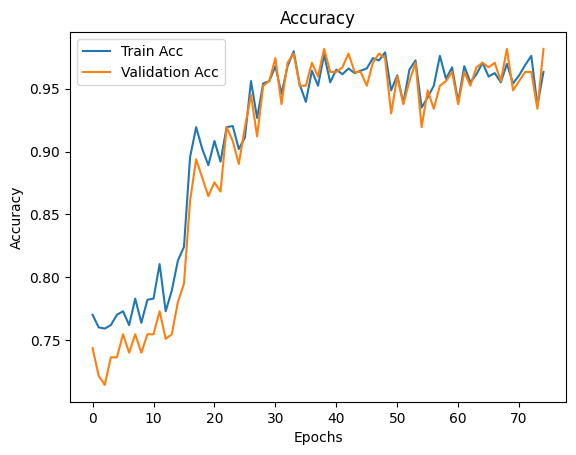

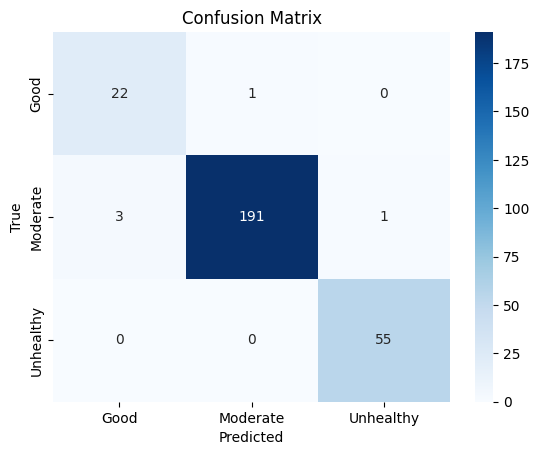

TabNet Test
              precision    recall  f1-score   support

           0     0.9167    0.9167    0.9167        12
           1     0.9913    0.9913    0.9913       115
           2     1.0000    1.0000    1.0000        25

    accuracy                         0.9868       152
   macro avg     0.9693    0.9693    0.9693       152
weighted avg     0.9868    0.9868    0.9868       152



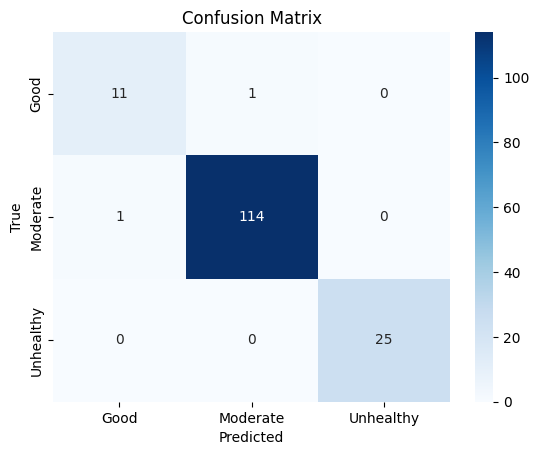

LSTM train and validation
9/9 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0     1.0000    0.7826    0.8780        23
           1     0.9698    0.9897    0.9797       195
           2     0.9643    0.9818    0.9730        55

    accuracy                         0.9707       273
   macro avg     0.9780    0.9181    0.9436       273
weighted avg     0.9713    0.9707    0.9698       273



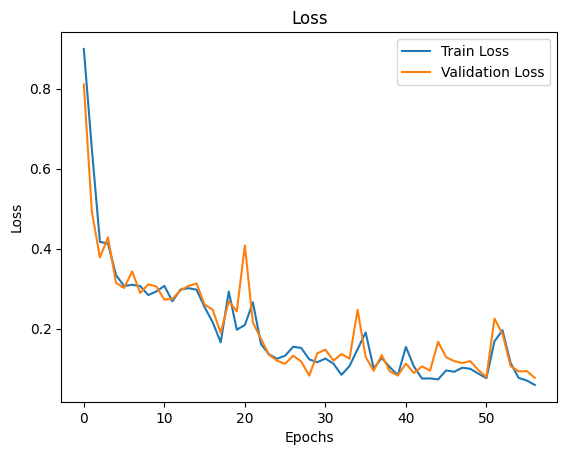

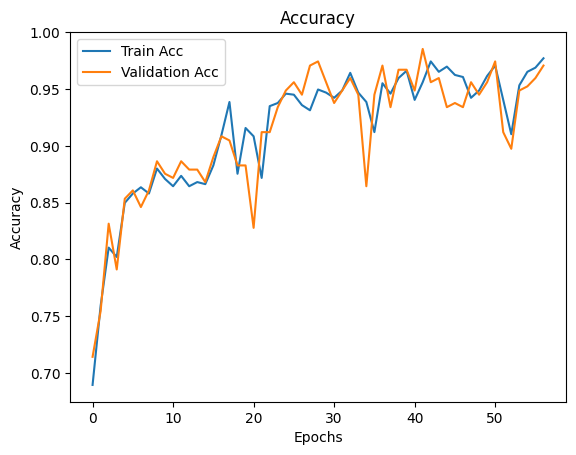

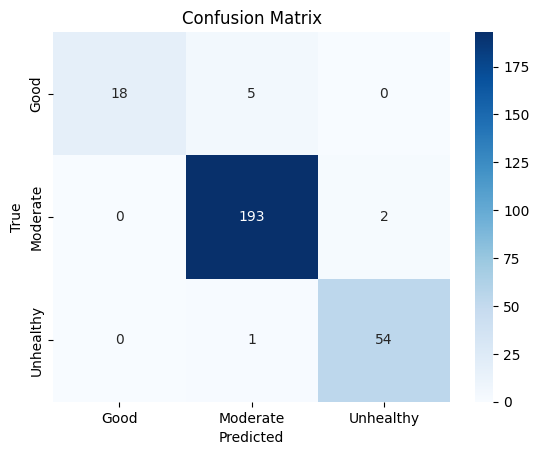

LSTM Test
5/5 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0     1.0000    0.8333    0.9091        12
           1     0.9829    1.0000    0.9914       115
           2     1.0000    1.0000    1.0000        25

    accuracy                         0.9868       152
   macro avg     0.9943    0.9444    0.9668       152
weighted avg     0.9871    0.9868    0.9863       152



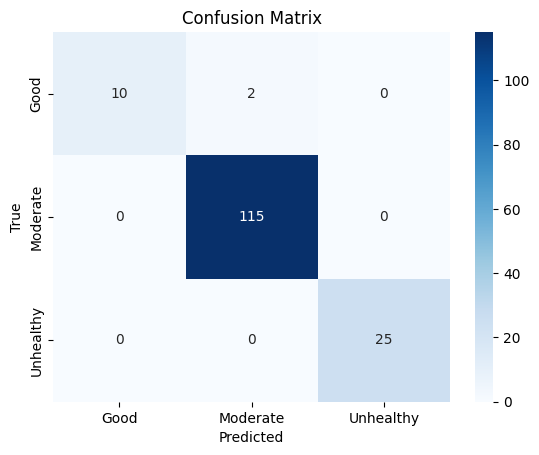

CNN train and validation
9/9 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0     0.8750    0.9130    0.8936        23
           1     0.9552    0.9846    0.9697       195
           2     1.0000    0.8727    0.9320        55

    accuracy                         0.9560       273
   macro avg     0.9434    0.9235    0.9318       273
weighted avg     0.9575    0.9560    0.9557       273



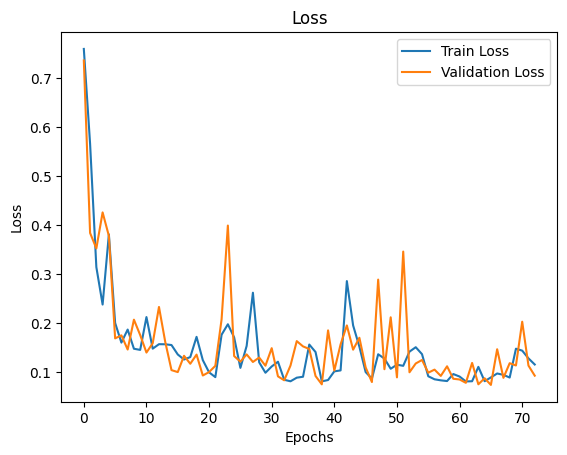

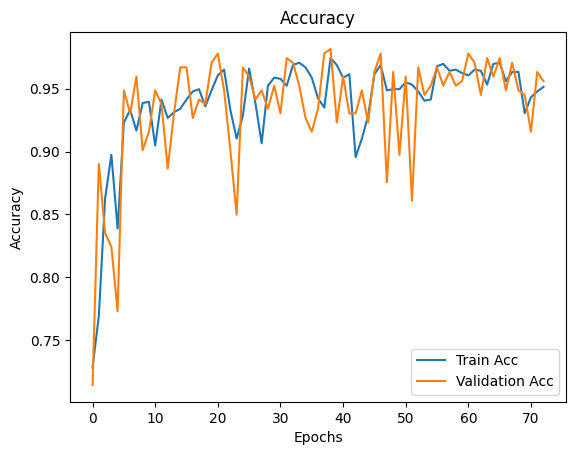

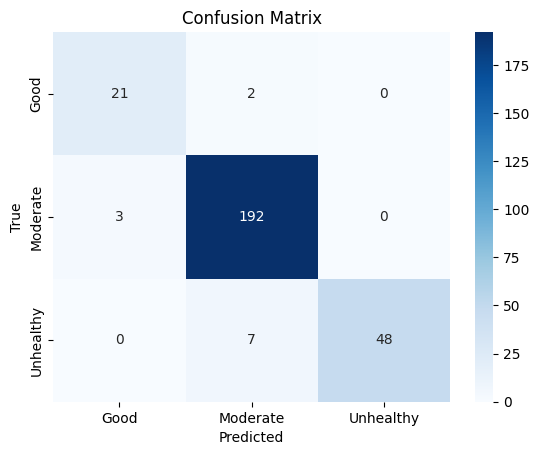

CNN Test
5/5 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0     1.0000    0.9167    0.9565        12
           1     0.9583    1.0000    0.9787       115
           2     1.0000    0.8400    0.9130        25

    accuracy                         0.9671       152
   macro avg     0.9861    0.9189    0.9494       152
weighted avg     0.9685    0.9671    0.9662       152



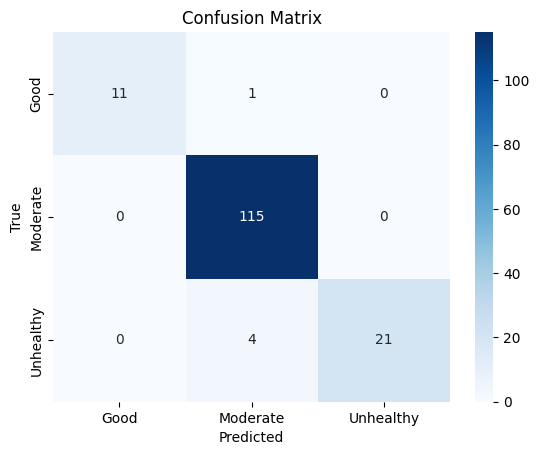


---- Training on Fold 2 ----
Stop training because you reached max_epochs = 75 with best_epoch = 66 and best_valid_accuracy = 0.9707
TabNet train and validation
              precision    recall  f1-score   support

           0     0.9167    0.8462    0.8800        26
           1     0.9714    0.9903    0.9808       206
           2     1.0000    0.9512    0.9750        41

    accuracy                         0.9707       273
   macro avg     0.9627    0.9292    0.9453       273
weighted avg     0.9705    0.9707    0.9703       273



/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


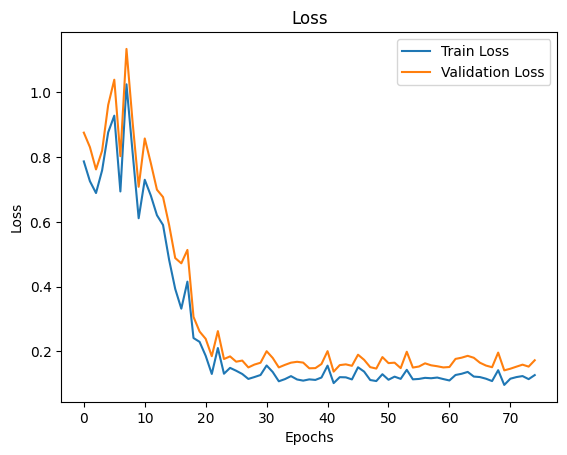

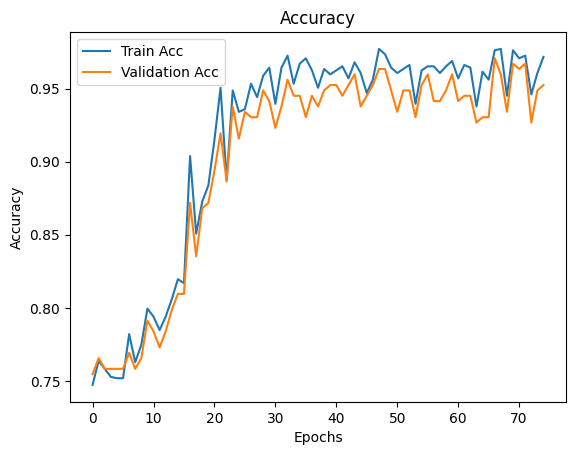

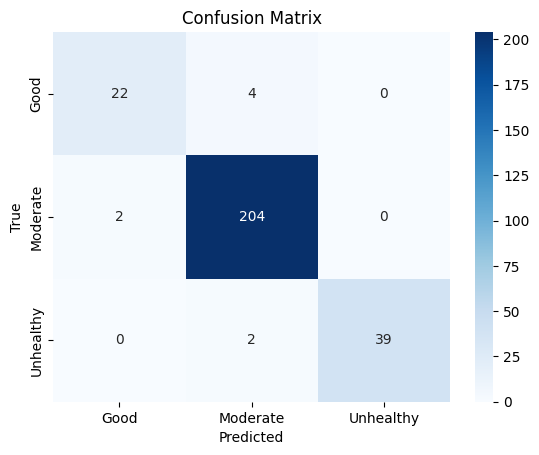

TabNet Test
              precision    recall  f1-score   support

           0     0.9000    0.7500    0.8182        12
           1     0.9744    0.9913    0.9828       115
           2     1.0000    1.0000    1.0000        25

    accuracy                         0.9737       152
   macro avg     0.9581    0.9138    0.9336       152
weighted avg     0.9727    0.9737    0.9726       152



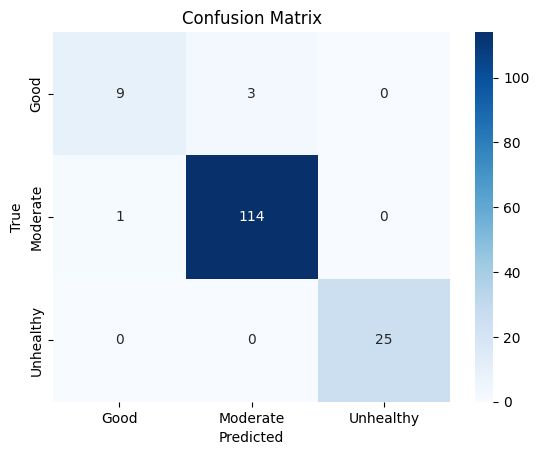

LSTM train and validation
9/9 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0     0.9444    0.6538    0.7727        26
           1     0.9512    0.9466    0.9489       206
           2     0.8000    0.9756    0.8791        41

    accuracy                         0.9231       273
   macro avg     0.8986    0.8587    0.8669       273
weighted avg     0.9279    0.9231    0.9216       273



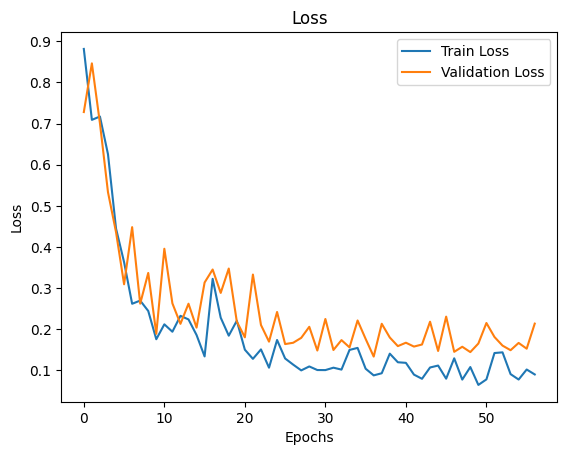

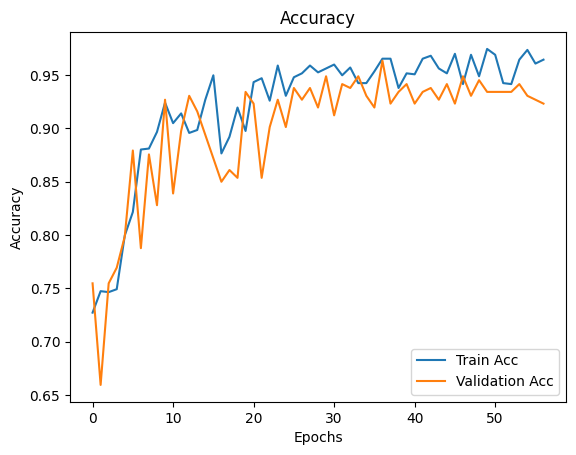

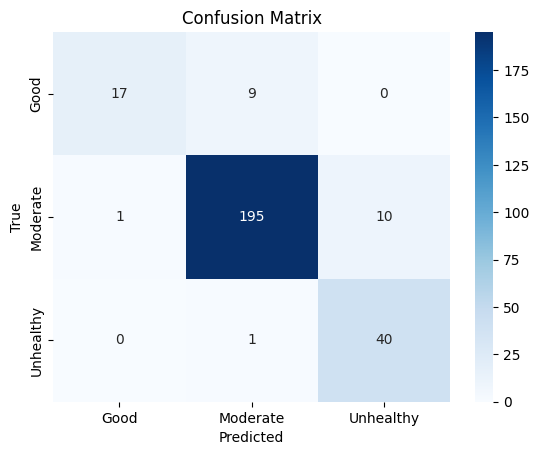

LSTM Test
5/5 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0     1.0000    0.7500    0.8571        12
           1     0.9739    0.9739    0.9739       115
           2     0.8929    1.0000    0.9434        25

    accuracy                         0.9605       152
   macro avg     0.9556    0.9080    0.9248       152
weighted avg     0.9626    0.9605    0.9597       152



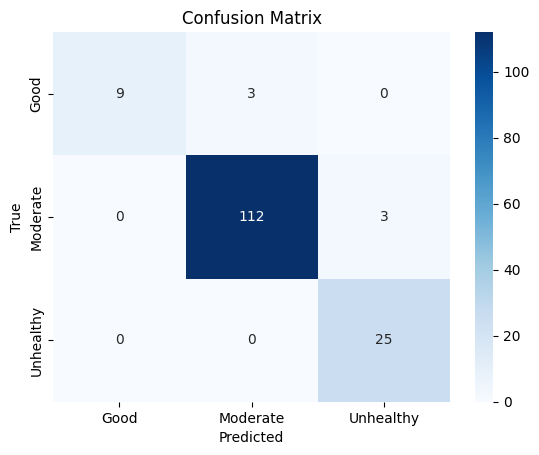

CNN train and validation
9/9 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0     0.9600    0.9231    0.9412        26
           1     0.9809    0.9951    0.9880       206
           2     1.0000    0.9512    0.9750        41

    accuracy                         0.9817       273
   macro avg     0.9803    0.9565    0.9680       273
weighted avg     0.9817    0.9817    0.9816       273



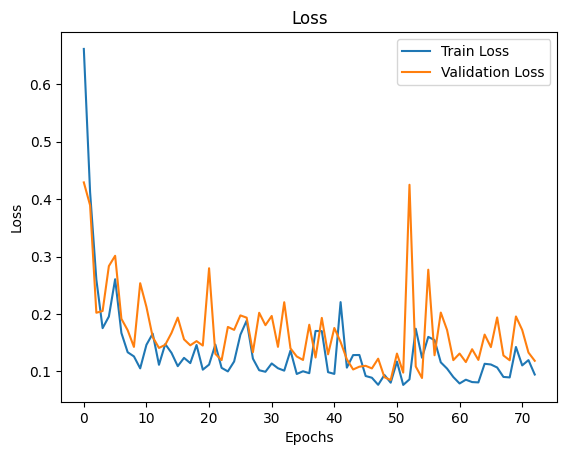

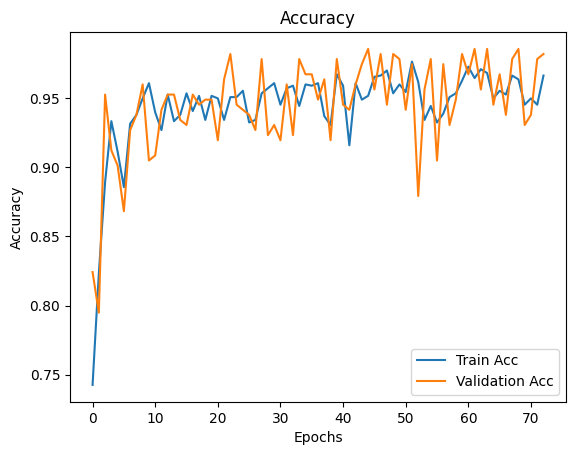

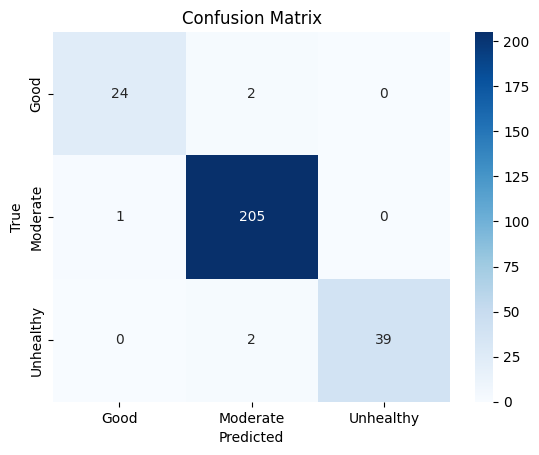

CNN Test
5/5 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0     1.0000    0.9167    0.9565        12
           1     0.9914    1.0000    0.9957       115
           2     1.0000    1.0000    1.0000        25

    accuracy                         0.9934       152
   macro avg     0.9971    0.9722    0.9841       152
weighted avg     0.9935    0.9934    0.9933       152



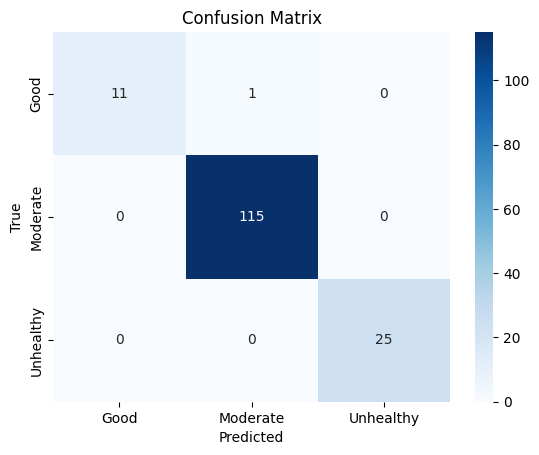


---- Training on Fold 3 ----
Stop training because you reached max_epochs = 75 with best_epoch = 32 and best_valid_accuracy = 0.97802
TabNet train and validation
              precision    recall  f1-score   support

           0     0.8947    0.8500    0.8718        20
           1     0.9810    0.9904    0.9856       208
           2     1.0000    0.9778    0.9888        45

    accuracy                         0.9780       273
   macro avg     0.9586    0.9394    0.9487       273
weighted avg     0.9778    0.9780    0.9778       273



/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


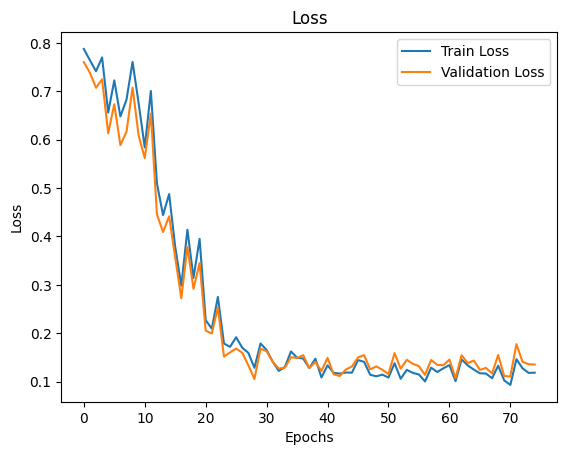

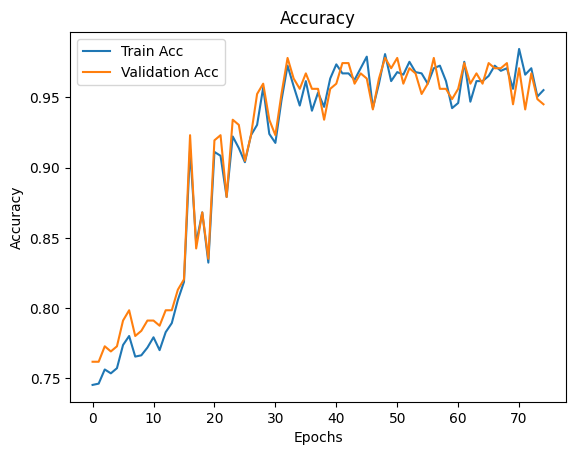

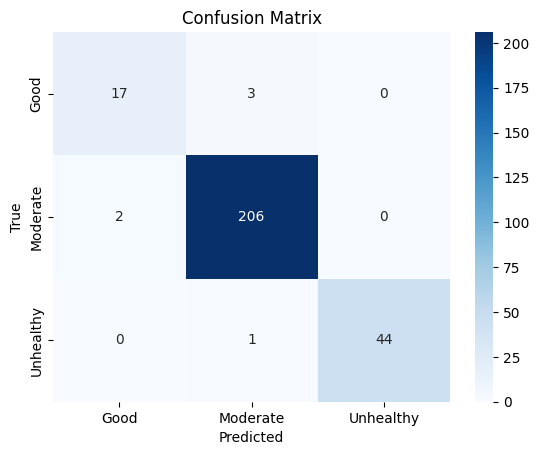

TabNet Test
              precision    recall  f1-score   support

           0     0.9091    0.8333    0.8696        12
           1     0.9828    0.9913    0.9870       115
           2     1.0000    1.0000    1.0000        25

    accuracy                         0.9803       152
   macro avg     0.9639    0.9415    0.9522       152
weighted avg     0.9798    0.9803    0.9799       152



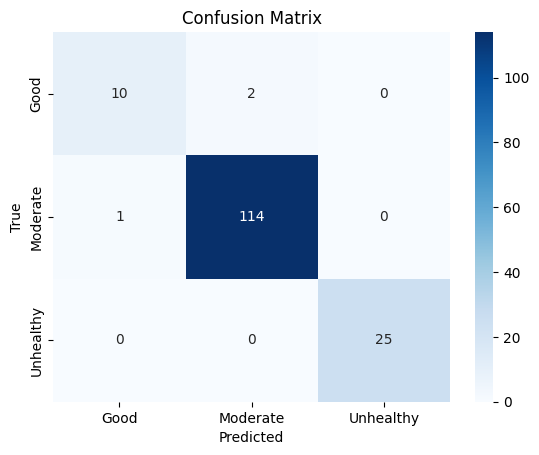

LSTM train and validation
9/9 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0     0.8636    0.9500    0.9048        20
           1     0.9762    0.9856    0.9809       208
           2     1.0000    0.9111    0.9535        45

    accuracy                         0.9707       273
   macro avg     0.9466    0.9489    0.9464       273
weighted avg     0.9719    0.9707    0.9708       273



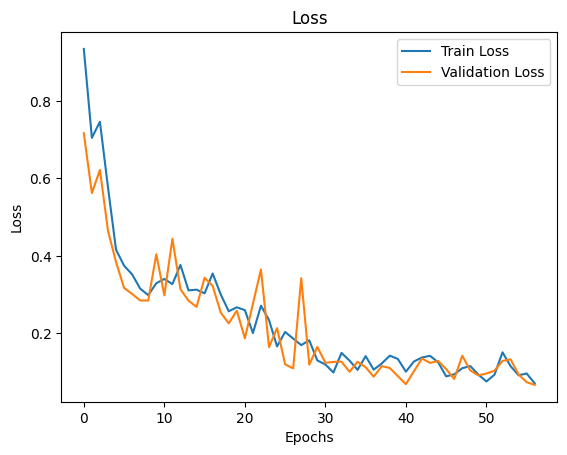

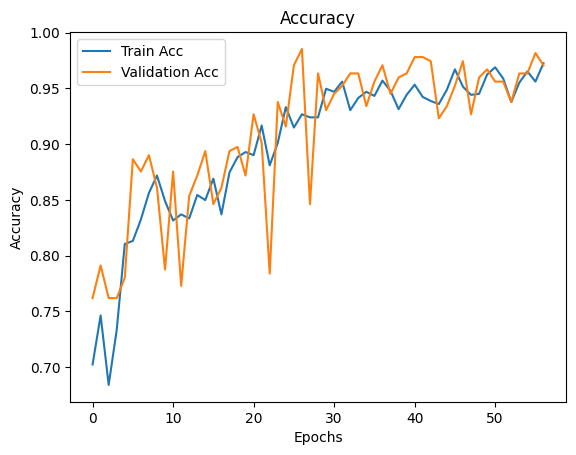

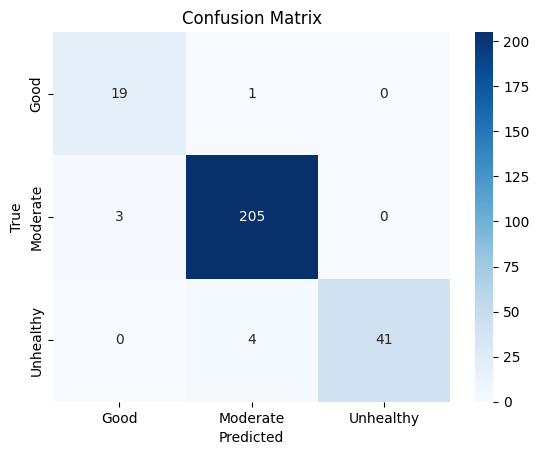

LSTM Test
5/5 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0     0.8571    1.0000    0.9231        12
           1     0.9826    0.9826    0.9826       115
           2     1.0000    0.9200    0.9583        25

    accuracy                         0.9737       152
   macro avg     0.9466    0.9675    0.9547       152
weighted avg     0.9756    0.9737    0.9739       152



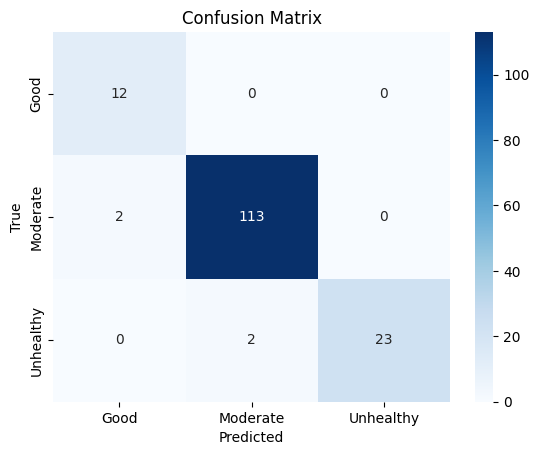

CNN train and validation
9/9 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0     0.9333    0.7000    0.8000        20
           1     0.9495    0.9952    0.9718       208
           2     1.0000    0.8889    0.9412        45

    accuracy                         0.9560       273
   macro avg     0.9610    0.8614    0.9043       273
weighted avg     0.9567    0.9560    0.9542       273



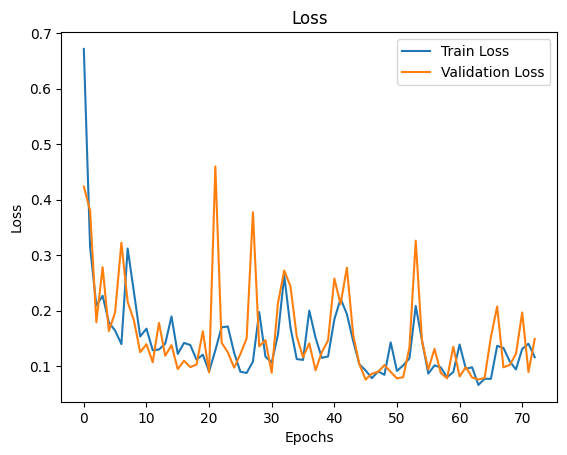

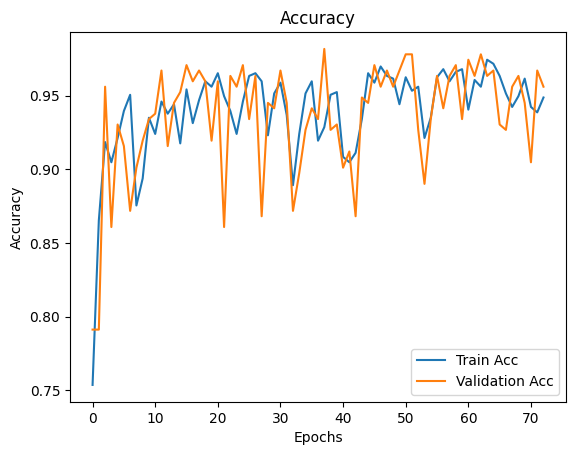

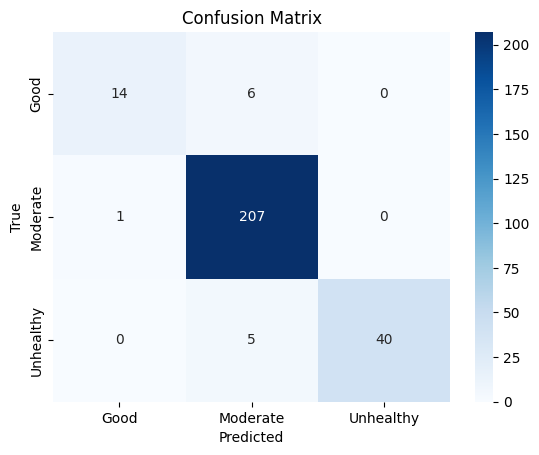

CNN Test
5/5 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0     1.0000    0.5833    0.7368        12
           1     0.9350    1.0000    0.9664       115
           2     1.0000    0.8800    0.9362        25

    accuracy                         0.9474       152
   macro avg     0.9783    0.8211    0.8798       152
weighted avg     0.9508    0.9474    0.9433       152



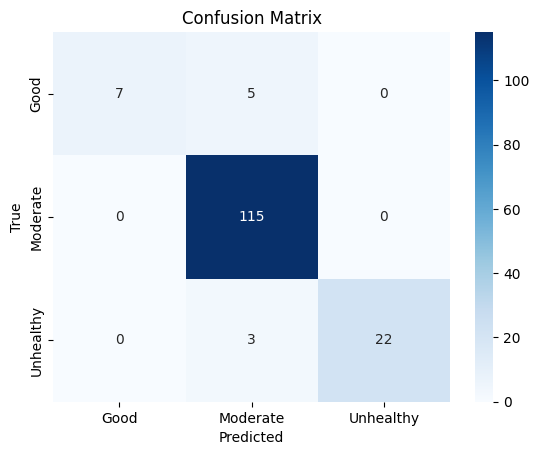


---- Training on Fold 4 ----
Stop training because you reached max_epochs = 75 with best_epoch = 74 and best_valid_accuracy = 0.98901
TabNet train and validation
              precision    recall  f1-score   support

           0     0.9091    1.0000    0.9524        10
           1     0.9910    0.9955    0.9932       220
           2     1.0000    0.9535    0.9762        43

    accuracy                         0.9890       273
   macro avg     0.9667    0.9830    0.9739       273
weighted avg     0.9894    0.9890    0.9890       273



/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


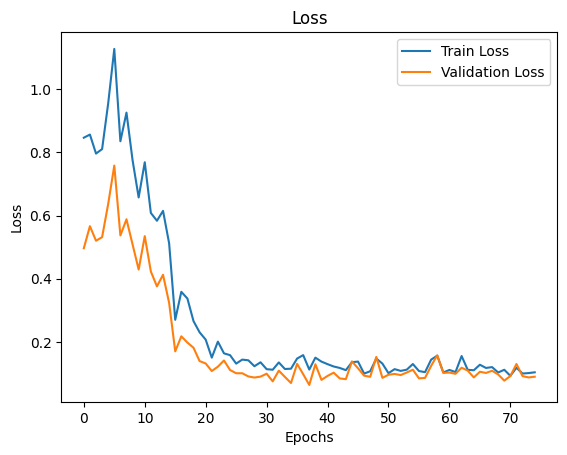

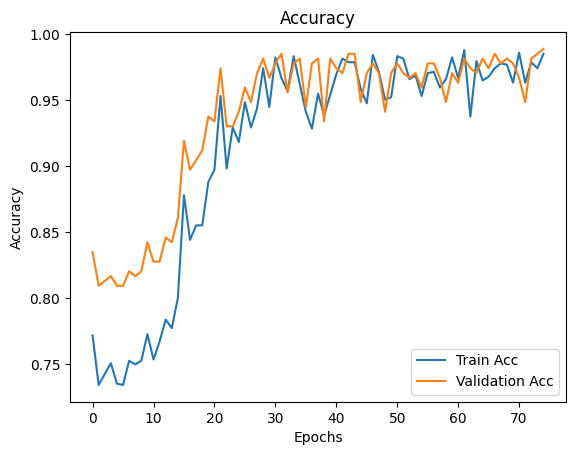

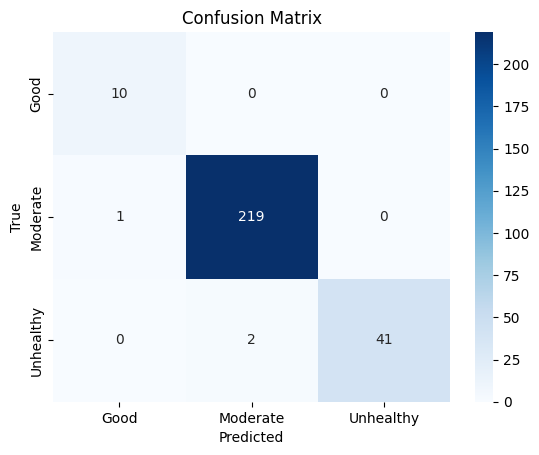

TabNet Test
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        12
           1     1.0000    1.0000    1.0000       115
           2     1.0000    1.0000    1.0000        25

    accuracy                         1.0000       152
   macro avg     1.0000    1.0000    1.0000       152
weighted avg     1.0000    1.0000    1.0000       152



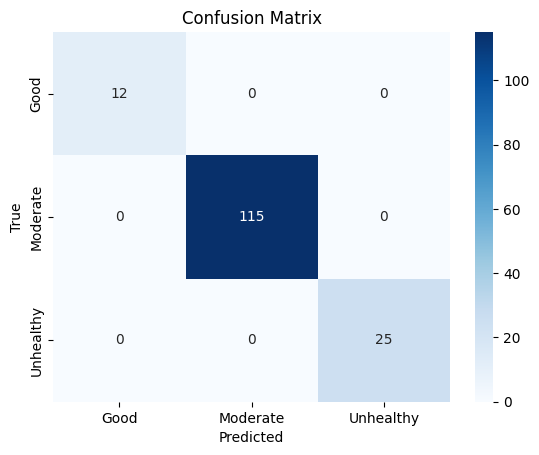

LSTM train and validation
9/9 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0     0.8000    0.8000    0.8000        10
           1     0.9520    0.9909    0.9710       220
           2     1.0000    0.7907    0.8831        43

    accuracy                         0.9524       273
   macro avg     0.9173    0.8605    0.8847       273
weighted avg     0.9540    0.9524    0.9509       273



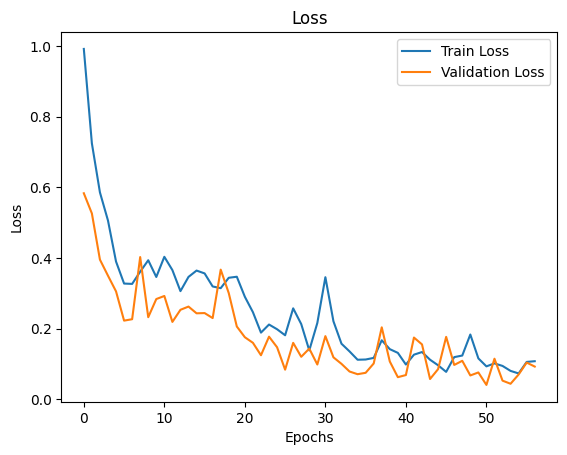

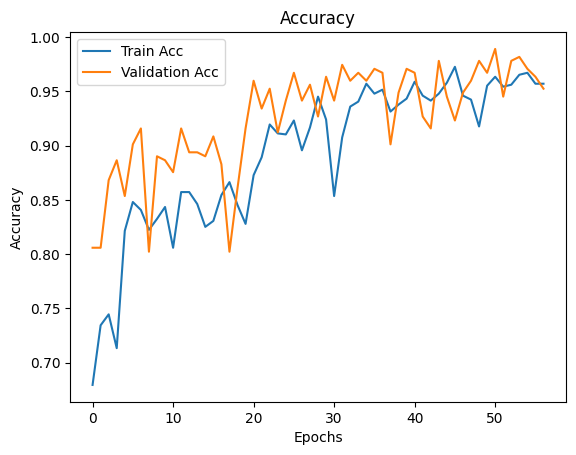

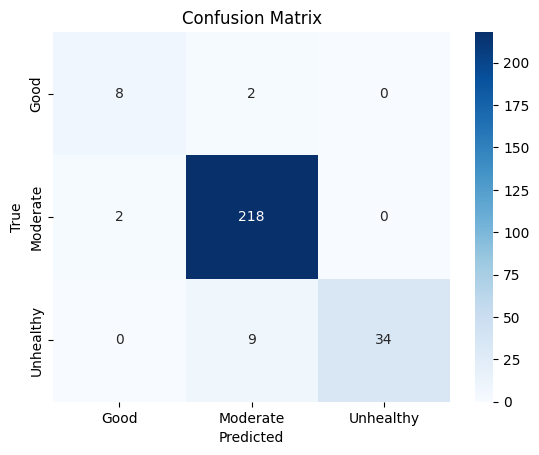

LSTM Test
5/5 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0     0.9091    0.8333    0.8696        12
           1     0.9580    0.9913    0.9744       115
           2     1.0000    0.8800    0.9362        25

    accuracy                         0.9605       152
   macro avg     0.9557    0.9015    0.9267       152
weighted avg     0.9610    0.9605    0.9598       152



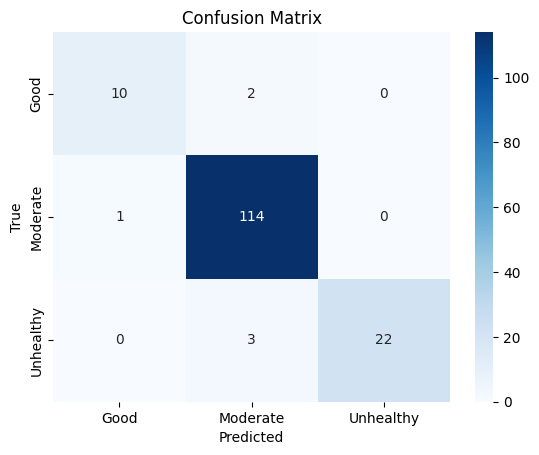

CNN train and validation
9/9 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0     0.6250    1.0000    0.7692        10
           1     0.9511    0.9727    0.9618       220
           2     1.0000    0.7442    0.8533        43

    accuracy                         0.9377       273
   macro avg     0.8587    0.9056    0.8615       273
weighted avg     0.9469    0.9377    0.9377       273



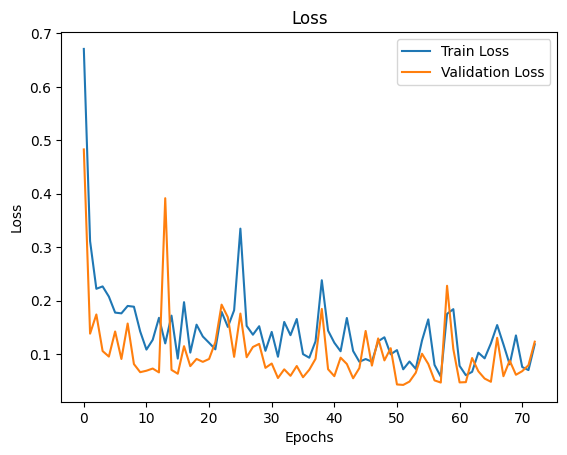

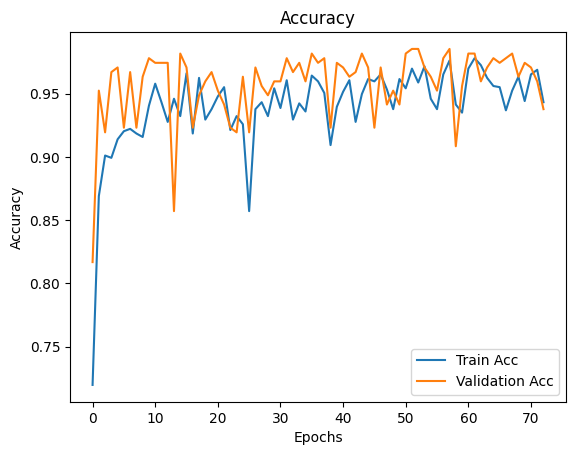

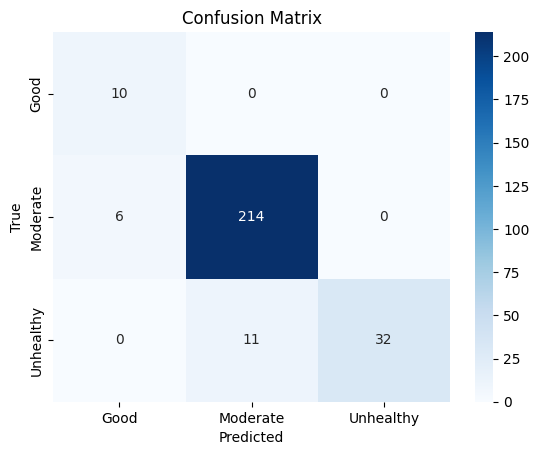

CNN Test
5/5 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0     0.8571    1.0000    0.9231        12
           1     0.9496    0.9826    0.9658       115
           2     1.0000    0.7600    0.8636        25

    accuracy                         0.9474       152
   macro avg     0.9356    0.9142    0.9175       152
weighted avg     0.9506    0.9474    0.9456       152



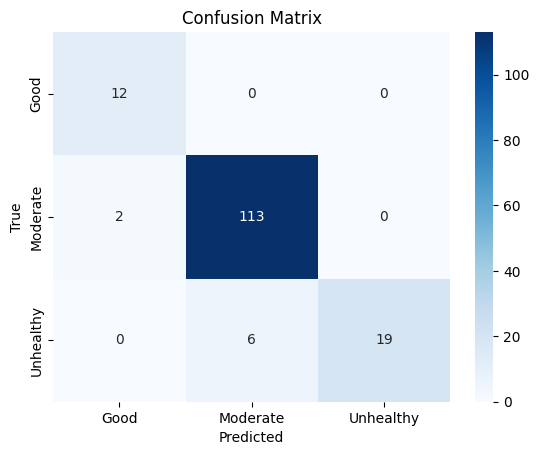


---- Training on Fold 5 ----
Stop training because you reached max_epochs = 75 with best_epoch = 46 and best_valid_accuracy = 0.97802
TabNet train and validation
              precision    recall  f1-score   support

           0     0.9200    0.9583    0.9388        24
           1     0.9795    0.9896    0.9845       193
           2     1.0000    0.9464    0.9725        56

    accuracy                         0.9780       273
   macro avg     0.9665    0.9648    0.9653       273
weighted avg     0.9785    0.9780    0.9780       273



/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


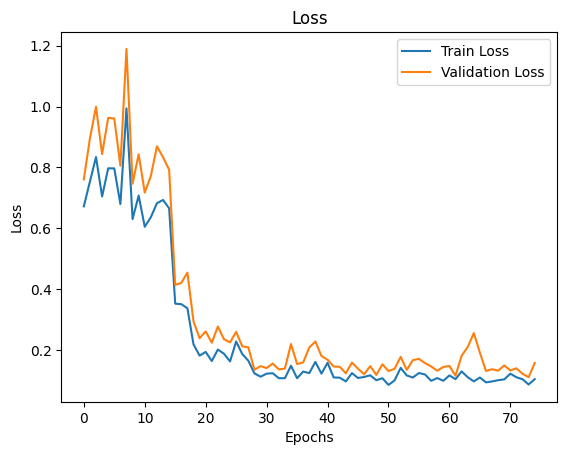

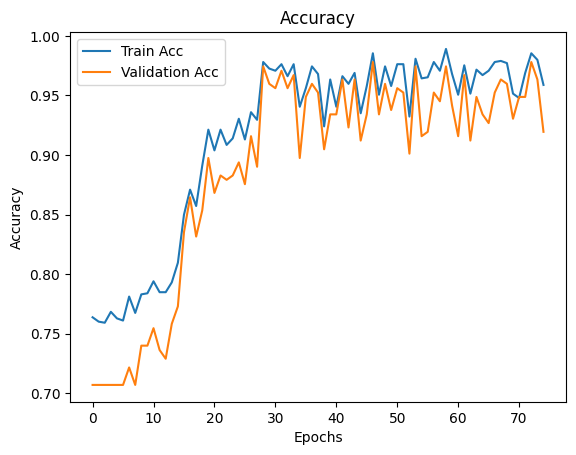

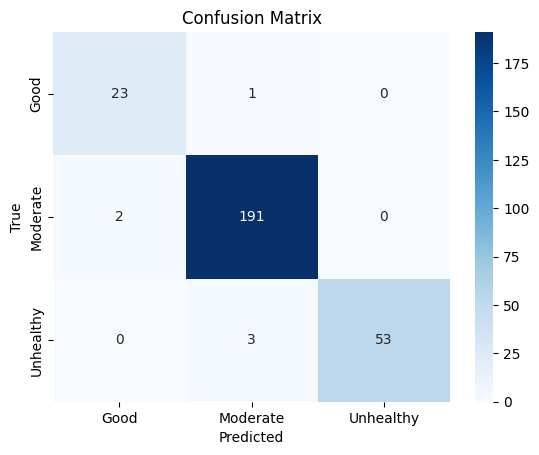

TabNet Test
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        12
           1     1.0000    1.0000    1.0000       115
           2     1.0000    1.0000    1.0000        25

    accuracy                         1.0000       152
   macro avg     1.0000    1.0000    1.0000       152
weighted avg     1.0000    1.0000    1.0000       152



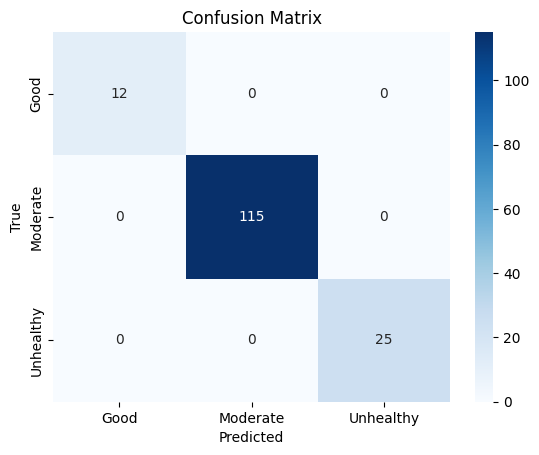

LSTM train and validation
9/9 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0     0.9565    0.9167    0.9362        24
           1     0.9648    0.9948    0.9796       193
           2     1.0000    0.9107    0.9533        56

    accuracy                         0.9707       273
   macro avg     0.9738    0.9407    0.9563       273
weighted avg     0.9713    0.9707    0.9704       273



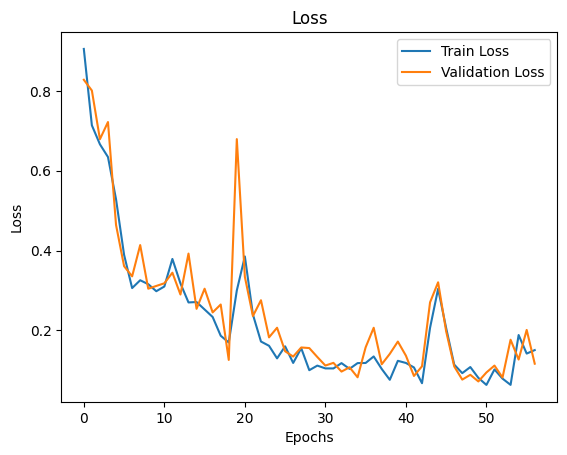

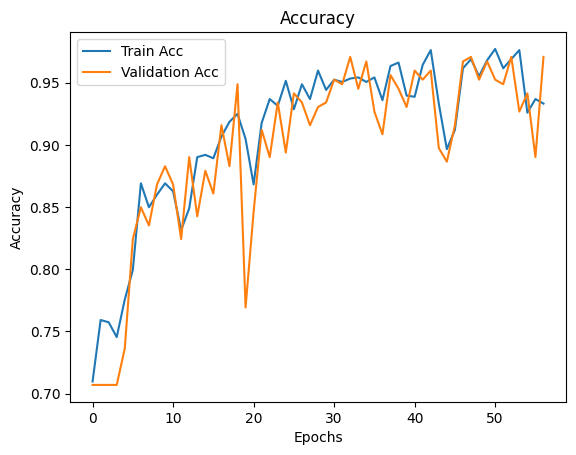

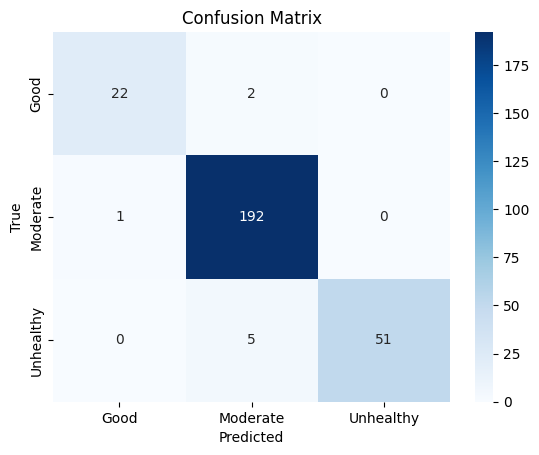

LSTM Test
5/5 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        12
           1     0.9664    1.0000    0.9829       115
           2     1.0000    0.8400    0.9130        25

    accuracy                         0.9737       152
   macro avg     0.9888    0.9467    0.9653       152
weighted avg     0.9746    0.9737    0.9728       152



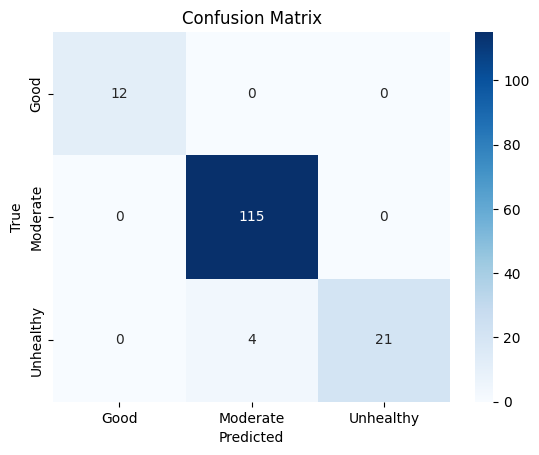

CNN train and validation
9/9 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0     0.8571    0.7500    0.8000        24
           1     0.9500    0.9845    0.9669       193
           2     1.0000    0.9286    0.9630        56

    accuracy                         0.9524       273
   macro avg     0.9357    0.8877    0.9100       273
weighted avg     0.9521    0.9524    0.9514       273



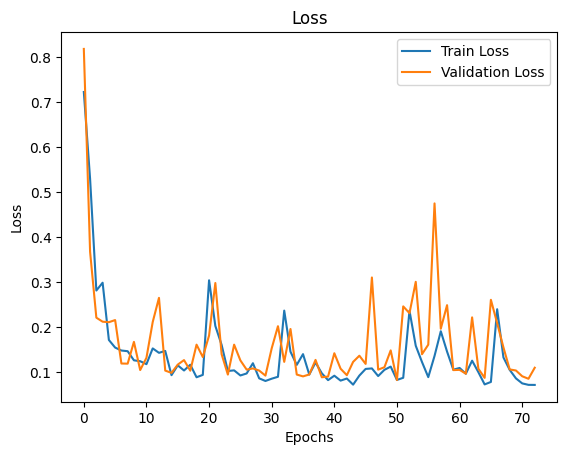

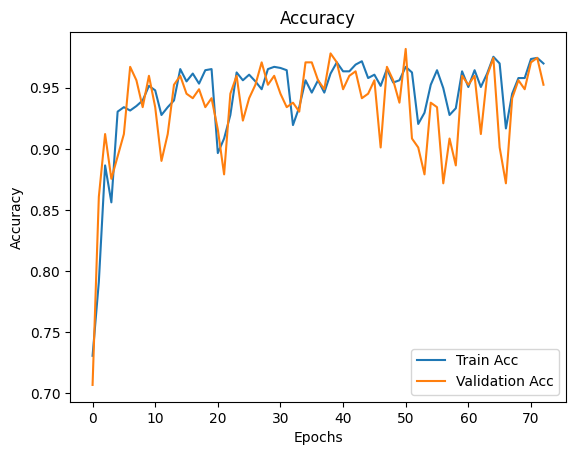

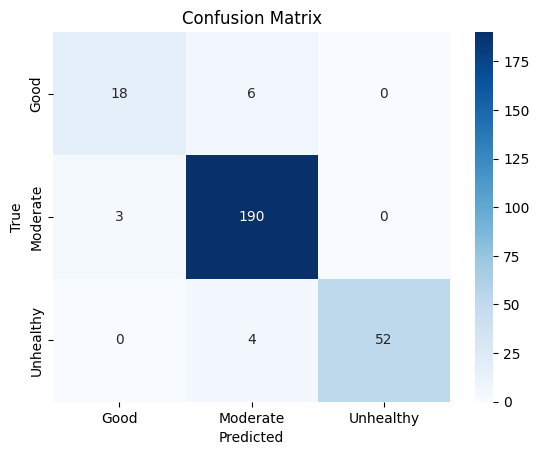

CNN Test
5/5 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0     1.0000    0.9167    0.9565        12
           1     0.9829    1.0000    0.9914       115
           2     1.0000    0.9600    0.9796        25

    accuracy                         0.9868       152
   macro avg     0.9943    0.9589    0.9758       152
weighted avg     0.9871    0.9868    0.9867       152



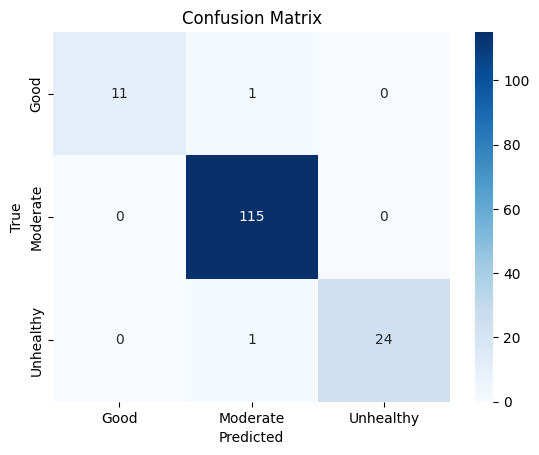


LSTM Average accuracy over 5-fold CV: 95.75%
CNN Average accuracy over 5-fold CV: 95.68%
Tabnet Average accuracy over 5-fold CV: 97.95%


In [ ]:
n_splits = 5
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
aug = ClassificationSMOTE(p=0.2)

acc_per_fold_lstm = []
acc_per_fold_cnn = []
acc_per_fold_tabnet = []

y_test_10_tabnet = np.argmax(y_test_10, axis=1)

for fold, (train, test) in enumerate(kfold.split(X_train_90, np.argmax(y_train_90, axis=1))):
    print(f"\n---- Training on Fold {fold + 1} ----")

    model_lstm = create_lstm_model()
    model_cnn = create_cnn_model(
        filters=38,
        kernel_size=3,
        dense_units=36,
        optimizer=Adam(learning_rate=0.07424181556238957)
    )

    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]

    y_train_tabnet = np.argmax(y_train, axis=1)
    y_test_tabnet = np.argmax(y_test, axis=1)

    #BEGIN Tabnet
    clf.fit(
        X_train, y_train_tabnet,
        eval_set=[(X_train, y_train_tabnet), (X_test, y_test_tabnet)],
        eval_name=['train', 'valid'],
        eval_metric=['logloss', 'accuracy'],
        max_epochs=75,
        patience=100,
        augmentations=aug,
        batch_size=50
    )

    predictions = clf.predict(X_test)
    accuracy = np.mean(predictions == y_test_tabnet)
    confusion = confusion_matrix(y_test_tabnet, predictions, labels=[0, 1, 2])    # Calculate the confusion matrix
    acc_per_fold_tabnet.append(accuracy * 100)
    print("TabNet train and validation")
    print(classification_report(y_test_tabnet, predictions, digits=4))
    create_grafik (
        train_loss=clf.history['train_logloss'],
        valid_loss=clf.history['valid_logloss'],
        train_accuracy=clf.history['train_accuracy'],
        valid_accuracy=clf.history['valid_accuracy']
    )
    createConfusionMatrix(confusion)

    predictions = clf.predict(X_test_10)
    # accuracy = np.mean(predictions == y_test_10_tabnet)
    print("TabNet Test")
    print(classification_report(y_test_10_tabnet, predictions, digits=4))
    confusion = confusion_matrix(y_test_10_tabnet, predictions, labels=[0, 1, 2])    # Calculate the confusion matrix
    createConfusionMatrix(confusion)

    #END Tabnet

    #BEGIN LSTM
    history_lstm = model_lstm.fit(X_train, y_train, epochs=57, batch_size=91, verbose=0, validation_data=(X_test, y_test))

    print("LSTM train and validation")
    scores = model_lstm.evaluate(X_test, y_test, verbose=0)
    acc_per_fold_lstm.append(scores[1] * 100)
    y_test_int = np.argmax(y_test, axis=1)
    y_pred = model_lstm.predict(X_test)
    confusion = confusion_matrix(y_test_int, np.argmax(y_pred, axis=1), labels=[0, 1, 2])    # Calculate the confusion matrix
    print(classification_report(y_test_int, np.argmax(y_pred, axis=1), digits=4))
    create_grafik (
        valid_loss=history_lstm.history['val_loss'],
        train_loss=history_lstm.history['loss'],
        train_accuracy=history_lstm.history['accuracy'],
        valid_accuracy=history_lstm.history['val_accuracy'],
    )
    createConfusionMatrix(confusion)

    print("LSTM Test")
    y_test_int = np.argmax(y_test_10, axis=1)
    y_pred = model_lstm.predict(X_test_10)
    print(classification_report(y_test_int, np.argmax(y_pred, axis=1), digits=4))
    confusion = confusion_matrix(y_test_int, np.argmax(y_pred, axis=1), labels=[0, 1, 2])    # Calculate the confusion matrix
    createConfusionMatrix(confusion)

    #END LSTM


    #BEGIN CNN
    history_cnn = model_cnn.fit(X_train, y_train, epochs=73, batch_size=44, verbose=0, validation_data=(X_test, y_test))
    print("CNN train and validation")
    scores = model_cnn.evaluate(X_test, y_test, verbose=0)
    acc_per_fold_cnn.append(scores[1] * 100)
    y_pred = model_cnn.predict(X_test)
    y_test_int = np.argmax(y_test, axis=1)
    print(classification_report(y_test_int, np.argmax(y_pred, axis=1), digits=4))
    create_grafik (
        valid_loss=history_cnn.history['val_loss'],
        train_loss=history_cnn.history['loss'],
        train_accuracy=history_cnn.history['accuracy'],
        valid_accuracy=history_cnn.history['val_accuracy'],
    )
    confusion = confusion_matrix(y_test_int, np.argmax(y_pred, axis=1), labels=[0, 1, 2])    # Calculate the confusion matrix
    createConfusionMatrix(confusion)

    print("CNN Test")
    y_test_int = np.argmax(y_test_10, axis=1)
    y_pred = model_cnn.predict(X_test_10)
    print(classification_report(y_test_int, np.argmax(y_pred, axis=1), digits=4))
    confusion = confusion_matrix(y_test_int, np.argmax(y_pred, axis=1), labels=[0, 1, 2])    # Calculate the confusion matrix
    createConfusionMatrix(confusion)

    #--END report--#

print(
    f"\nLSTM Average accuracy over {n_splits}-fold CV: {np.mean(acc_per_fold_lstm):.2f}%")

print(
    f"CNN Average accuracy over {n_splits}-fold CV: {np.mean(acc_per_fold_cnn):.2f}%")

print(
    f"Tabnet Average accuracy over {n_splits}-fold CV: {np.mean(acc_per_fold_tabnet):.2f}%")


# Kode bebas

In [ ]:
import pandas as pd

data = {
    'Model': ['Tabnet', 'LSTM', 'CNN'],
    'Precision': [97.57, 93.29, 93.27],
    'Recall': [95.72, 91.21, 92.54],
    'F1 Score': [96.51, 91.90, 92.52],
    'Accuracy': [98.17, 95.90, 95.60]
}

df = pd.DataFrame(data)
df

Model  Precision  Recall  F1 Score  Accuracy
0  Tabnet      97.57   95.72     96.51     98.17
1    LSTM      93.29   91.21     91.90     95.90
2     CNN      93.27   92.54     92.52     95.60

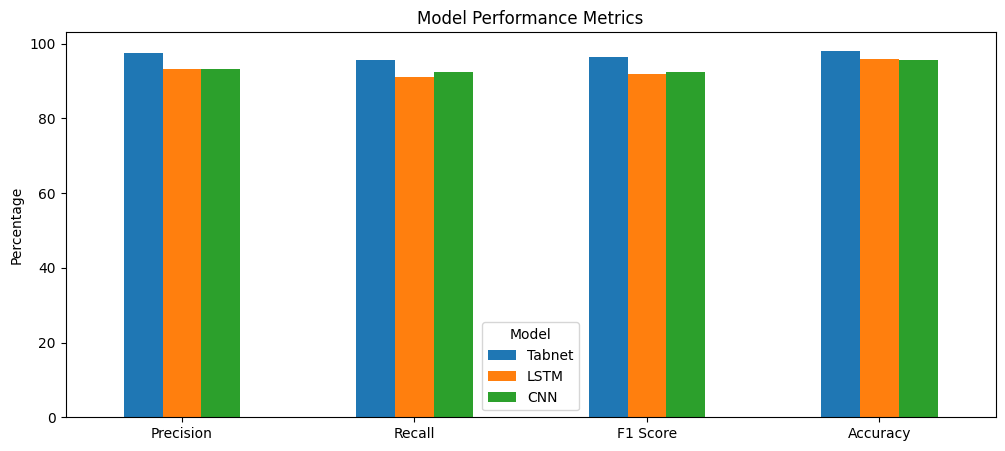

In [ ]:
# Set the 'Model' column as the index
# df.set_index('Model', inplace=True)

# # Transpose the DataFrame to have metrics as columns
# df = df.T

# Plot the data as a bar chart
df.plot(kind='bar', figsize=(12, 5))
plt.title('Model Performance Metrics')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.show()